In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/results/logs_all.pkl
/kaggle/input/results/logs_smt.pkl
/kaggle/input/results/logs.pkl
/kaggle/input/results/results_multi.csv
/kaggle/input/results/dict_results_all.pkl
/kaggle/input/supervised-learning-regression/wine_train.csv
/kaggle/input/supervised-learning-regression/wine_test.csv


In [2]:
# imports
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import boxcox, median_abs_deviation

from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, log_loss, cohen_kappa_score, accuracy_score, r2_score
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import lightgbm as lgb

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import catboost as cat
import xgboost as xgb 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Initializing datasets

In [4]:
train_path = '/kaggle/input/supervised-learning-regression/wine_train.csv'
test_path = '/kaggle/input/supervised-learning-regression/wine_test.csv'

In [5]:
df_train = pd.read_csv(train_path, usecols=
                       [
                           'fixed acidity', 
                           'volatile acidity',
                           'citric acid',
                           'residual sugar',
                           'chlorides',
                           'free sulfur dioxide',
                           'total sulfur dioxide',
                           'density',
                           'pH',
                           'sulphates',
                           'alcohol',
                           'wine_type',
                           'target'
                       ])

df_test = pd.read_csv(test_path)

### Linear regression

In [6]:
X_train_scaled = StandardScaler().fit_transform(df_train.drop(columns='target'))
y_train = df_train.target

X_test = df_test.drop(columns='wine_ID')
X_test_scaled = StandardScaler().fit_transform(X_test)


In [7]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled,
                                                                            y_train,
                                                                            shuffle=False,
                                                                            test_size=0.2)
linear_reg = LinearRegression()
linear_reg.fit(X_train_split, y_train_split)

y_test_hat = linear_reg.predict(X_test_split)
print(f"Mean Squared error: {mean_squared_error(y_test_split, y_test_hat)}")

Mean Squared error: 0.5032970318156685


In [8]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

results = linear_reg.predict(X_test_scaled)

df_results = pd.DataFrame({'target':results, 'wine_ID':df_test['wine_ID']})
print(f'R2: {linear_reg.score(X_train_scaled, y_train)}')
#df_results.to_csv('results.csv', index=False)

R2: 0.3049128256154897


### Logistic regression

Mean Squared error: 0.5868131868131868


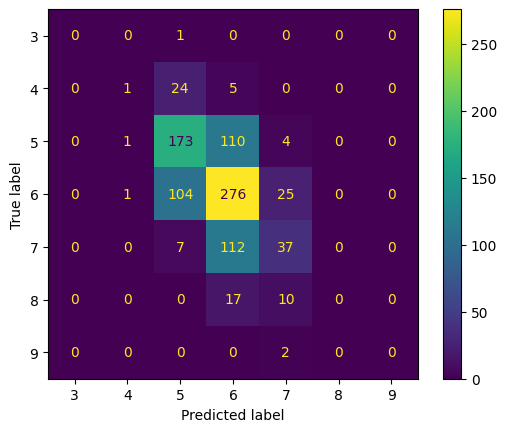

In [9]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled,
                                                                            y_train,
                                                                            shuffle=False,
                                                                            test_size=0.2)
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train_split, y_train_split)

y_test_hat = logistic_reg.predict(X_test_split)

print(f"Mean Squared error: {mean_squared_error(y_test_split, y_test_hat)}")

conf_matrix = confusion_matrix(y_test_split, y_test_hat, labels=y_train.sort_values().unique())
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = y_train.sort_values().unique())

cm_display.plot()
plt.show()

In [10]:
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train_scaled, y_train)

results = linear_reg.predict(X_test_scaled)
df_results = pd.DataFrame({'target':results, 'wine_ID':df_test['wine_ID']})


In [11]:
logistic_reg.score(X_train_scaled, y_train)

0.5504728392346602

Using this two basic models, it seems that the classification models work better.

Let's see if splitting the datasets according to the wine type will improve the results.

### Creating the splitted data

In [12]:
df_train_white = df_train.loc[df_train.wine_type == 1].drop(columns='wine_type')
df_train_red = df_train.loc[df_train.wine_type == 0].drop(columns='wine_type')

df_test_white = df_test.loc[df_test.wine_type == 1].drop(columns='wine_type')
df_test_red = df_test.loc[df_test.wine_type == 0].drop(columns='wine_type')

In [13]:
X_train_scaled_w = StandardScaler().fit_transform(df_train_white.drop(columns='target'))
y_train_w = df_train_white.target

X_train_scaled_r = StandardScaler().fit_transform(df_train_red.drop(columns='target'))
y_train_r = df_train_red.target

X_test_r = df_test_red.drop(columns='wine_ID')
X_test_w = df_test_white.drop(columns='wine_ID')
X_test_scaled_r = StandardScaler().fit_transform(X_test_r)
X_test_scaled_w = StandardScaler().fit_transform(X_test_w)

In [14]:
X_train_split_r, X_test_split_r, y_train_split_r, y_test_split_r = train_test_split(X_train_scaled_r,
                                                                            y_train_r,
                                                                            shuffle=False,
                                                                            test_size=0.2)

X_train_split_w, X_test_split_w, y_train_split_w, y_test_split_w = train_test_split(X_train_scaled_w,
                                                                            y_train_w,
                                                                            shuffle=False,
                                                                            test_size=0.2)

linear_reg_r = LinearRegression()
linear_reg_w = LinearRegression()
linear_reg_r.fit(X_train_split_r, y_train_split_r)
linear_reg_w.fit(X_train_split_w, y_train_split_w)

y_test_hat_w = linear_reg_w.predict(X_test_split_w)
y_test_hat_r = linear_reg_r.predict(X_test_split_r)
y_test_hat = np.concatenate([y_test_hat_w, y_test_hat_r])
y_test_true = np.concatenate([y_test_split_w, y_test_split_r])
print(f"Mean Squared error: {mean_squared_error(y_test_true, y_test_hat)}")

Mean Squared error: 0.49853624557099213


It seems like splitting the dataset doesn't improve the linea regression result.

In [15]:
linear_reg_w = LinearRegression()
linear_reg_r = LinearRegression()
linear_reg_r.fit(X_train_scaled_r, y_train_r)
linear_reg_w.fit(X_train_scaled_w, y_train_w)

resulrs_r = linear_reg_r.predict(X_test_scaled_r)
resulrs_w = linear_reg_w.predict(X_test_scaled_w)

df_res_r = pd.DataFrame({'target':resulrs_r, 'wine_ID':df_test_red['wine_ID']})
df_res_w = pd.DataFrame({'target':resulrs_w, 'wine_ID':df_test_white['wine_ID']})
df_res = pd.concat([df_res_r, df_res_w])
#df_res.to_csv('results.csv', index = False)

Let's try the same thing with the logistic regression of scikit learn

Mean Squared error: 0.6147091108671789


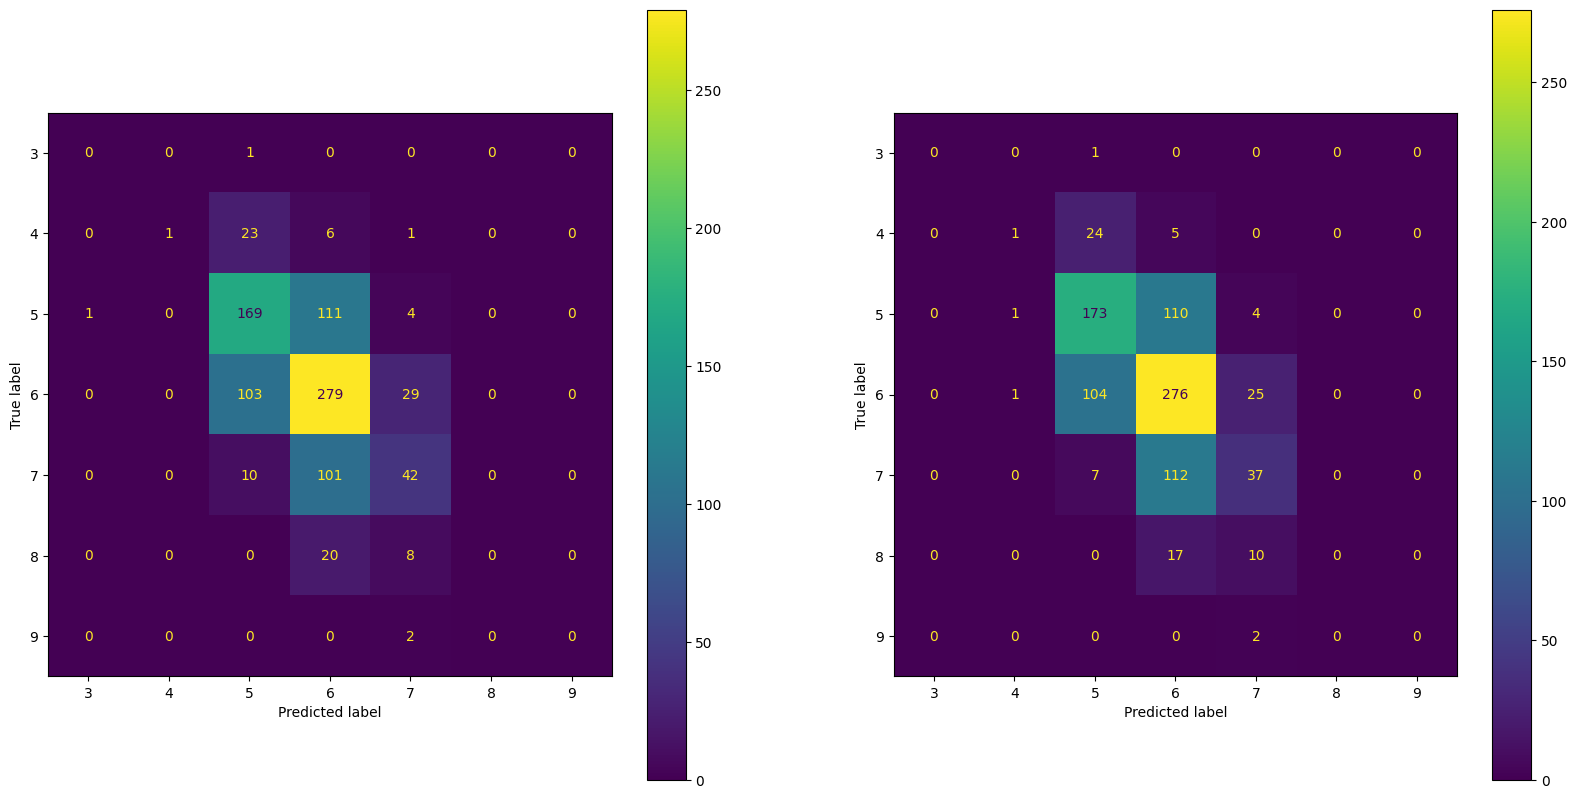

In [16]:
logistic_reg_r = LogisticRegression(max_iter=1000)
logistic_reg_w = LogisticRegression(max_iter=1000)
logistic_reg_r.fit(X_train_split_r, y_train_split_r)
logistic_reg_w.fit(X_train_split_w, y_train_split_w)

y_test_hat_w = logistic_reg_w.predict(X_test_split_w)
y_test_hat_r = logistic_reg_r.predict(X_test_split_r)
y_test_hat = np.concatenate([y_test_hat_w, y_test_hat_r])
y_test_true = np.concatenate([y_test_split_w, y_test_split_r])
print(f"Mean Squared error: {mean_squared_error(y_test_true, y_test_hat)}")


conf_matrix = confusion_matrix(y_test_true, y_test_hat, labels=y_train.sort_values().unique())
cm_display_2 = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = y_train.sort_values().unique())

fig, ax = plt.subplots(1, 2, figsize = (20,10))
cm_display_2.plot(ax=ax[0])
cm_display.plot(ax=ax[1])
plt.show()

According to the confusion matrix it seems that the prediction are a bit better. 

In [17]:
logistic_reg_w = LogisticRegression(max_iter=1000)
logistic_reg_r = LogisticRegression(max_iter=1000)
logistic_reg_r.fit(X_train_scaled_r, y_train_r)
logistic_reg_w.fit(X_train_scaled_w, y_train_w)

resulrs_r = logistic_reg_r.predict(X_test_scaled_r)
resulrs_w = logistic_reg_w.predict(X_test_scaled_w)

df_res_r = pd.DataFrame({'target':resulrs_r, 'wine_ID':df_test_red['wine_ID']})
df_res_w = pd.DataFrame({'target':resulrs_w, 'wine_ID':df_test_white['wine_ID']})
df_res = pd.concat([df_res_r, df_res_w])
df_res.to_csv('results.csv', index = False)

As show by the MSE of the dataset, we can see that the logistic regression performs worse than the linear regression.

### Random Forests

In [18]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = list(range(1,13))
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
max_samples = list(np.arange(0.1,1, 0.1))
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_samples': max_samples          
              }

In [19]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)
#rf_random.fit(X_train_scaled, y_train)

In [20]:
best_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'criterion': 'squared_error',
    'max_depth': 20,
    'max_features': 8,
    'max_leaf_nodes': None,
    'max_samples': 0.8,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 800,
    'n_jobs': None,
    'oob_score': False,
    'random_state': None,
    'verbose': 0,
    'warm_start': False
}
best_random = RandomForestRegressor(**best_params)
best_random.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, max_features=8, max_samples=0.8,
                      n_estimators=800)

In [21]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_split, y_train_split)
base_accuracy = evaluate(base_model, X_test_split, y_test_split)
best_random = best_random
random_accuracy = evaluate(best_random, X_test_split, y_test_split)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 0.4708 degrees.
Accuracy = 91.80%.
Model Performance
Average Error: 0.2080 degrees.
Accuracy = 96.36%.
Improvement of 4.97%.


In [22]:
best_random.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, max_features=8, max_samples=0.8,
                      n_estimators=800)

In [23]:
results = best_random.predict(X_test_scaled)
df_results = pd.DataFrame({'target':results, 'wine_ID':df_test['wine_ID']})
#df_results.to_csv('results.csv', index = False)

Let's see if the results improve it we train two random forest regressor on the white and red wine and then use thse two models for the predictions.

In [24]:
best_rf_white = RandomForestRegressor(**best_params)
best_rf_red = RandomForestRegressor(**best_params)

best_rf_white.fit(X_train_scaled_w, y_train_w)
best_rf_red.fit(X_train_scaled_r, y_train_r)

resulrs_r = best_rf_red.predict(X_test_scaled_r)
resulrs_w = best_rf_white.predict(X_test_scaled_w)

df_res_r = pd.DataFrame({'target':resulrs_r, 'wine_ID':df_test_red['wine_ID']})
df_res_w = pd.DataFrame({'target':resulrs_w, 'wine_ID':df_test_white['wine_ID']})
df_res = pd.concat([df_res_r, df_res_w])
df_res.to_csv('results.csv', index = False)

### Data analysis for prediction improvement

#### Analyse de la normalité des features

In [25]:
skew_df = df_train.drop('target',axis =1).skew(numeric_only=True).sort_values()
print("Skewly distributed columns by skewness value:\n") 
display(skew_df)

Skewly distributed columns by skewness value:



total sulfur dioxide    0.008531
citric acid             0.293075
pH                      0.379491
alcohol                 0.553898
density                 0.737531
wine_type               1.156098
free sulfur dioxide     1.400210
volatile acidity        1.507550
residual sugar          1.591345
fixed acidity           1.718318
sulphates               1.871392
chlorides               5.645273
dtype: float64

In [26]:
kurtosis_df = df_train.drop('target',axis =1).kurtosis().sort_values()
print("Tailed columns by kurtosis value\n") 
display(kurtosis_df)

Tailed columns by kurtosis value



wine_type               -0.663729
alcohol                 -0.557027
total sulfur dioxide    -0.329614
pH                       0.347470
citric acid              1.083061
volatile acidity         2.902528
fixed acidity            4.768679
residual sugar           6.231645
sulphates                9.241466
density                  9.523429
free sulfur dioxide     10.574441
chlorides               56.383320
dtype: float64

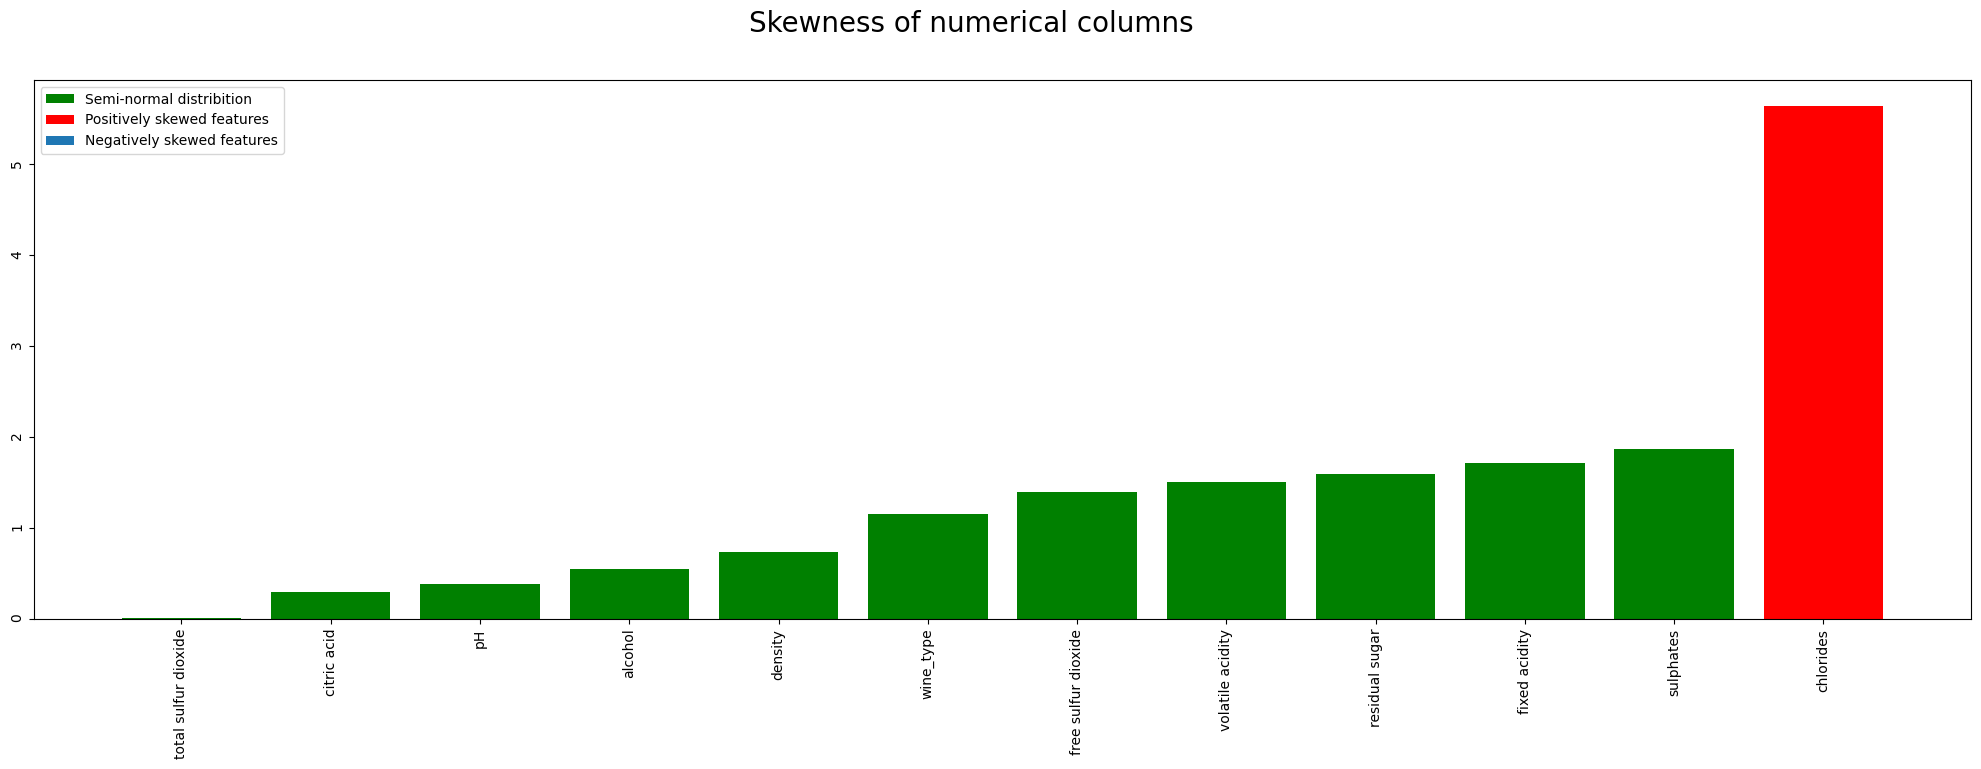

In [27]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = skew_df[(skew_df<2)& (skew_df>-2)].index, height = skew_df[(skew_df<2)& (skew_df>-2)], color = "g", label= "Semi-normal distribition")
ax.bar(x = skew_df[skew_df>2].index, height = skew_df[skew_df>2], color = "r", label = "Positively skewed features")
ax.bar(x = skew_df[skew_df<-2].index, height = skew_df[skew_df<-2], color = "b", label = "Negatively skewed features")
ax.legend()
fig.suptitle("Skewness of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

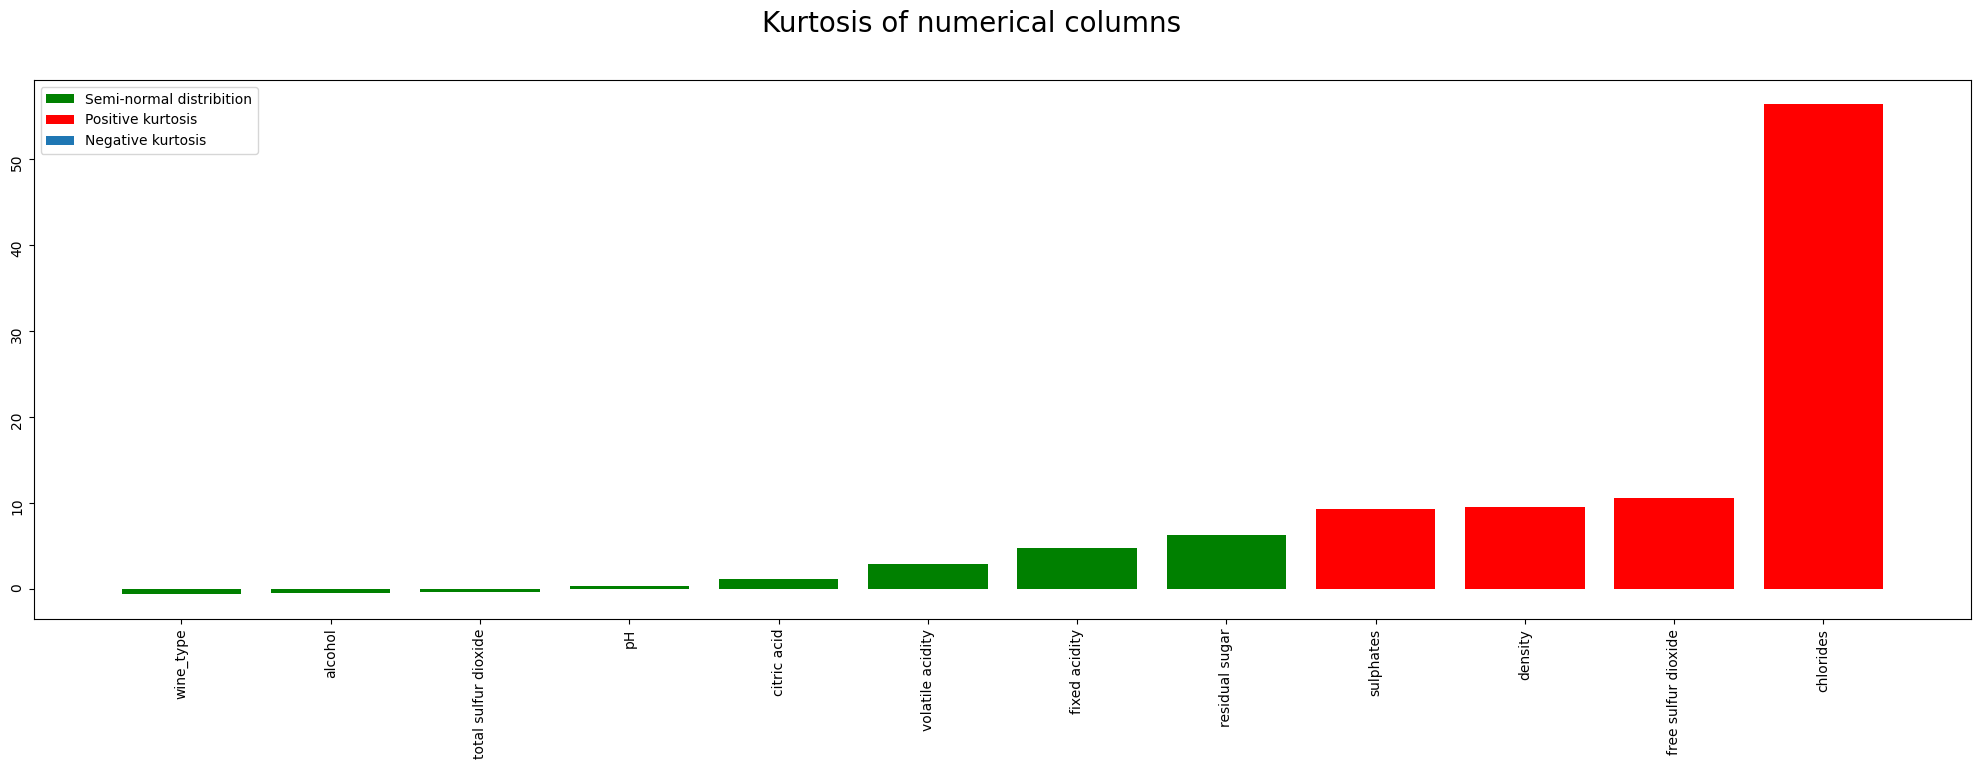

In [28]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)].index, height = kurtosis_df[(kurtosis_df<7)& (kurtosis_df>-7)], color = "g", label= "Semi-normal distribition")
ax.bar(x = kurtosis_df[kurtosis_df>7].index, height = kurtosis_df[kurtosis_df>7], color = "r", label = "Positive kurtosis")
ax.bar(x = kurtosis_df[kurtosis_df<-7].index, height = kurtosis_df[kurtosis_df<-7], color = "b",  label = "Negative kurtosis")
ax.legend()
fig.suptitle("Kurtosis of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)

Le degré de distribution des données pour une distribution normale affecte les performances de certains modèles (en particulier les modèles linéaires).

En tant que tel, nous devons essayer de corriger ces caractéristiques qui ont un kurtosis et un skewness positifs/négatifs.

Solution potentielle : Transformation de la distribution (guassienne) Étudier les transformations pour créer des caractéristiques normalement distribuées (transformation logarithmique, caractéristiques cubiques, boxcox, mise à l'échelle, etc.)

En particulier les colonnes : 'sulphates', 'residual sugar', 'chlorides', car elles présentent un aplatissement et une asymétrie élevés.

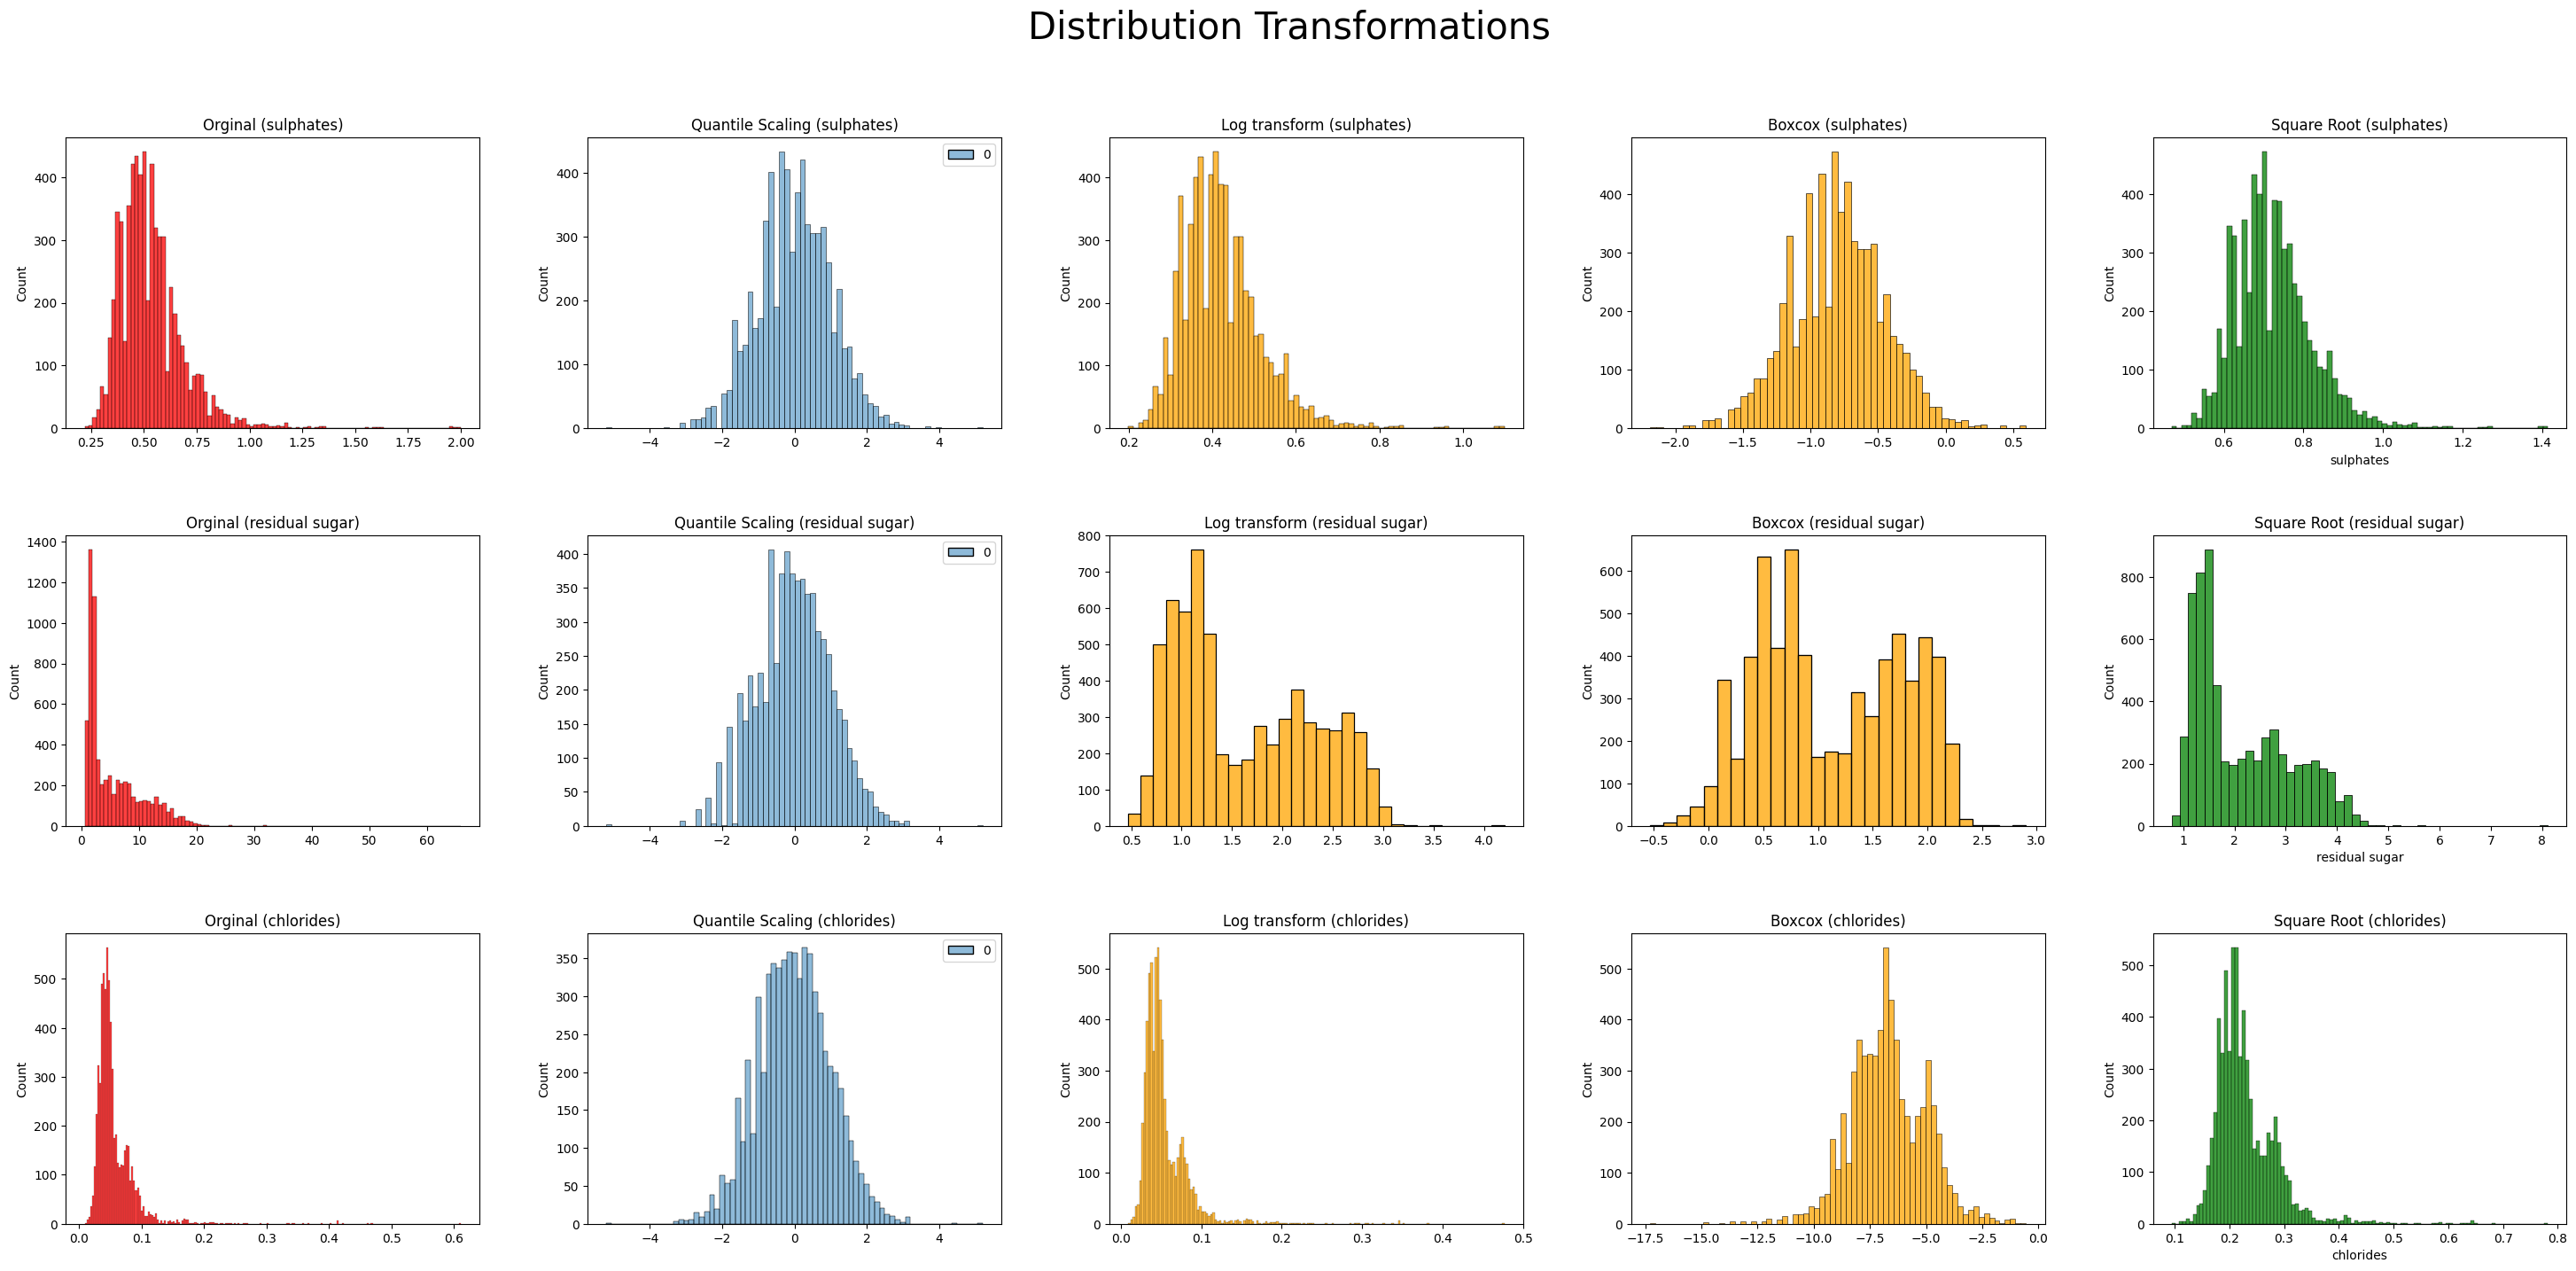

In [29]:
df_all = pd.concat([df_train, df_test.drop('wine_ID', axis = 1)], axis = 0)
non_dist_cols = ['sulphates', 'residual sugar', 'chlorides']
fig,ax = plt.subplots(len(non_dist_cols),5, figsize = (30,15))
for i,col in enumerate(non_dist_cols):
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(df_all[[col]])

    sns.histplot(x= df_all[col],ax= ax[i,0], color = "r")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log1p(df_all[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(df_all[col])[0], ax = ax[i,3], color= "orange")
    except:
        pass
    sns.histplot(np.sqrt(df_all[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 30)
plt.tight_layout(pad = 4)
plt.show()

Le quantile scaling semble être la transformation la plus efficace pour normaliser les trois colonnes qui présentent une distribution non gaussienne.

Nous allons donc transformer les colonnes avec la transformation Quantive Scaling.

In [30]:
# Transformation du Dataset de train
scaler = QuantileTransformer(output_distribution="normal")
quant_df = scaler.fit_transform(df_train[non_dist_cols])
df_train[non_dist_cols] = quant_df

In [31]:
# Transformation du Dataset de train
scaler = QuantileTransformer(output_distribution="normal")
quant_df = scaler.fit_transform(df_test[non_dist_cols])
df_test[non_dist_cols] = quant_df

#### Analyse des corrélations

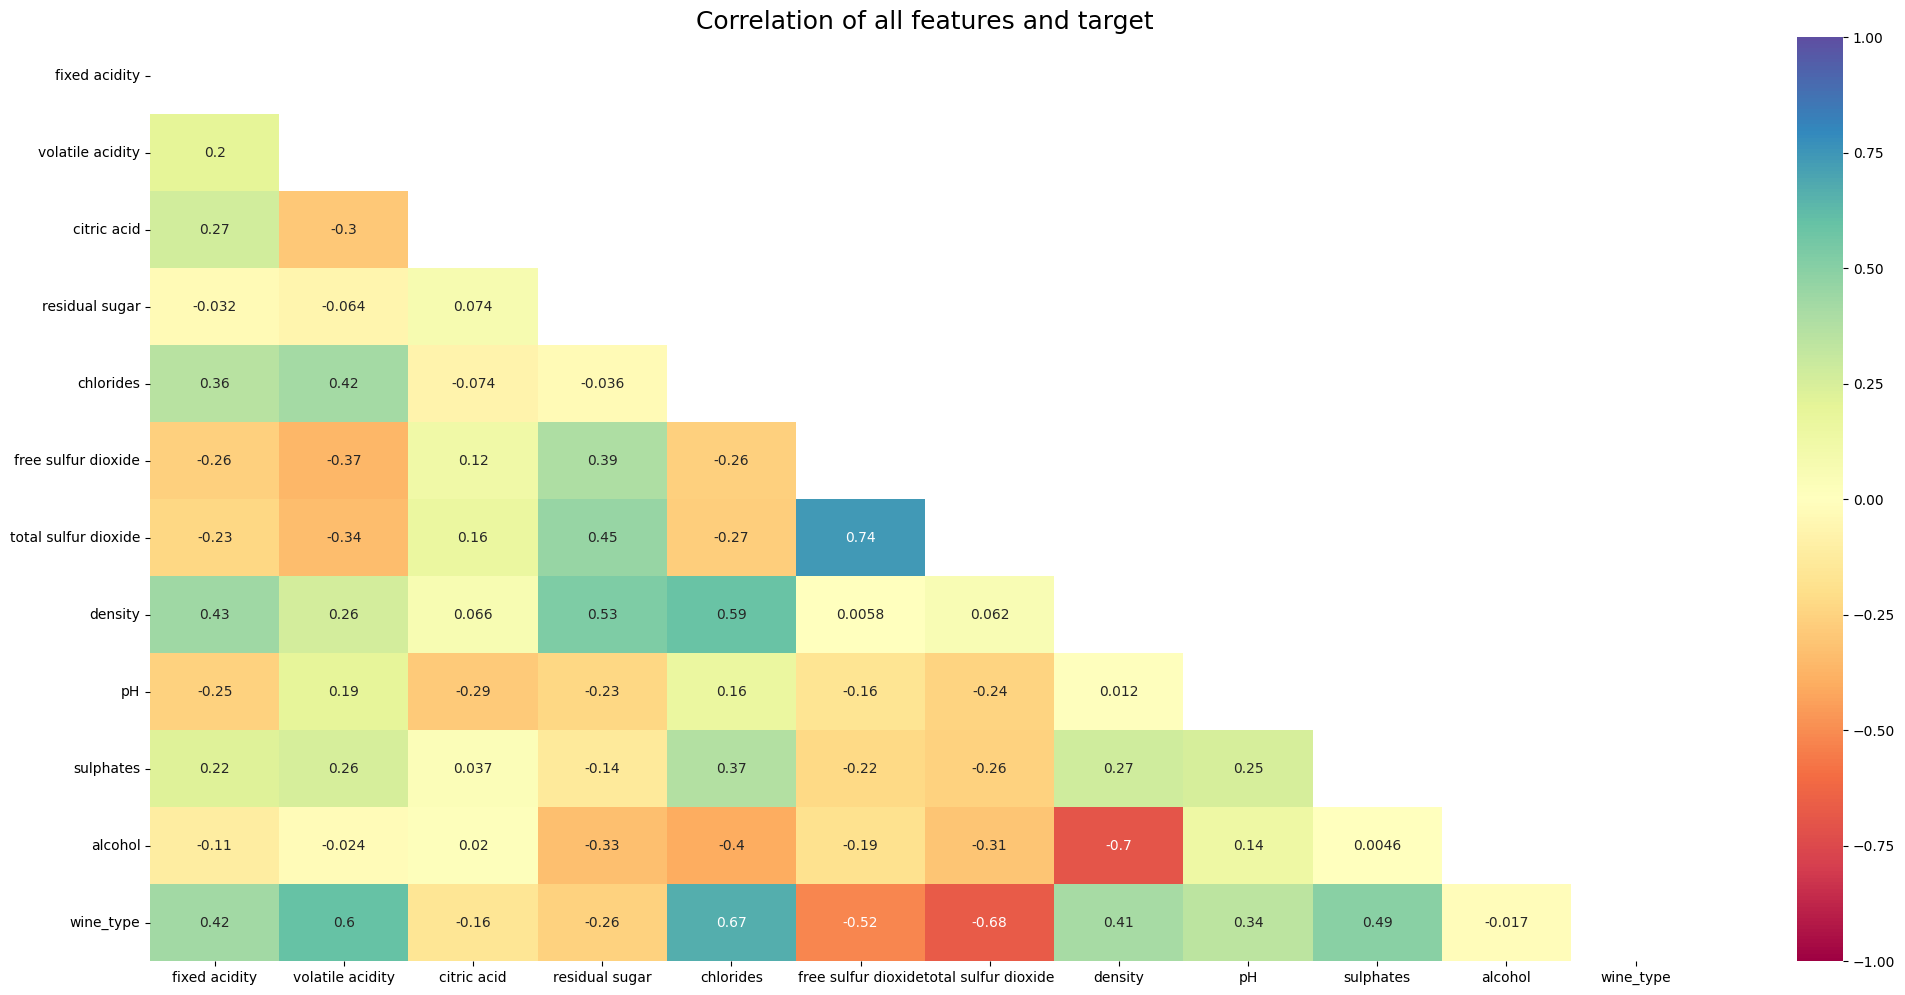

In [32]:
plt.figure(figsize = (25,12))

corr = pd.concat([df_train.drop('target',axis =1), df_test.drop('wine_ID', axis=1)], axis =0).corr('spearman')
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

Les colonnes qui contiennent des informations similaires (corrélées / mutuelles) ont un impact négatif sur certains modèles, car elles peuvent entraîner de l'overfitting.

Forte corrélation entre un certain nombre de caractéristiques, par exemple :
* 'free sulfur dioxide' et 'total sulfur dioxide' ont une forte corrélation positive
* 'density' and 'alcohol' ont une forte corrélation négative
* 'density' and 'chlorides' ont une forte corrélation négative

In [33]:
def select_features(df):
    df_trn = pd.get_dummies(df,drop_first =True) #onehotencoding needed for categorical columns 
    X_train, X_test, y_train, y_test = train_test_split(df_trn.drop('target',axis =1), df_trn['target'], test_size=0.33, random_state=1) 
    
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    columns = X_train.columns
    return X_train_fs, X_test_fs, fs, columns 

# feature selection
dataset = df_train.drop('wine_type', axis=1)
X_train_fs, X_test_fs, fs, columns = select_features(dataset)

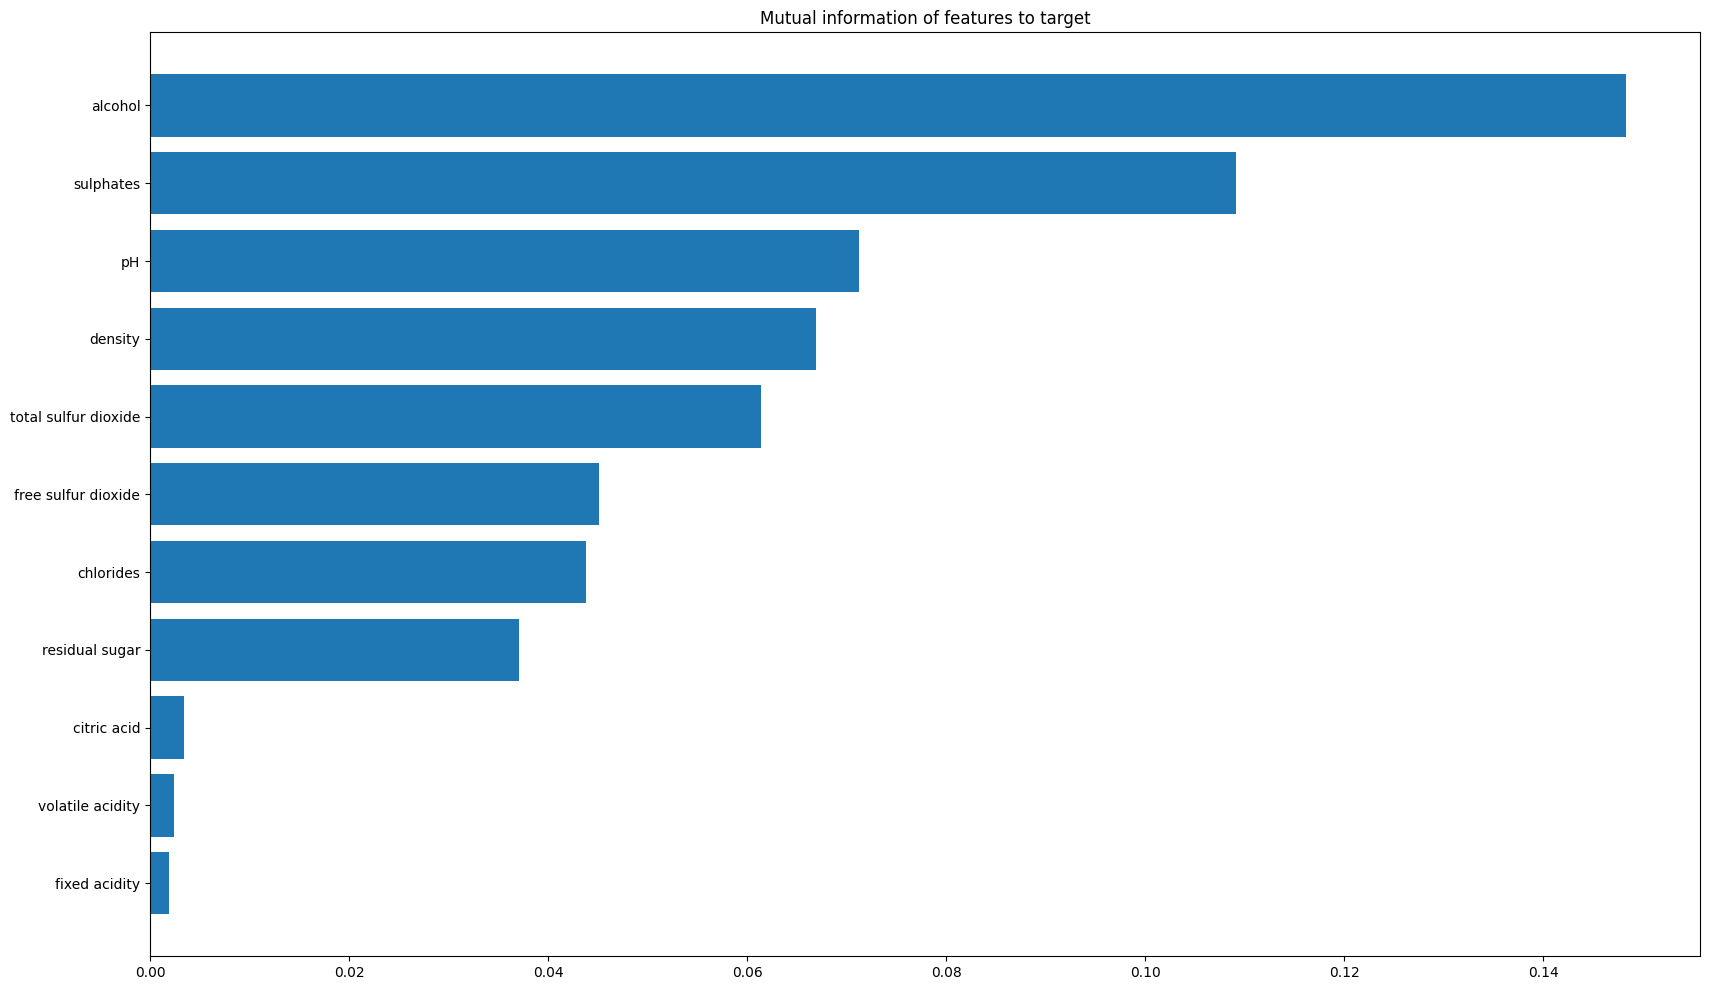

In [34]:
selected_feats = pd.DataFrame(fs.scores_, index = columns).sort_values(by = 0 , ascending = True)

fig,ax = plt.subplots(figsize =(20,12))
plt.barh(y =columns, width= selected_feats[0])
plt.title("Mutual information of features to target")
plt.show()

Nous pouvons conclure que certaines caractéristiques dépendent fortement de notre cible ('alcohol' for instance). Il pourrait être utile par la suite de faire du feature engineering sur le features importants comme 'alcohol'

En outre, on observe qu'il y'a peu d'information mutuelles pour "fixed acidity" et "volatile acidity" et il pourrait être possible de les supprimer. 

Toutefois, nous noterons ces caractéristiques et nous entraînerons notre modèle pour confirmer l'importance des caractéristiques ci-dessous.


#### Recherche d'outliers

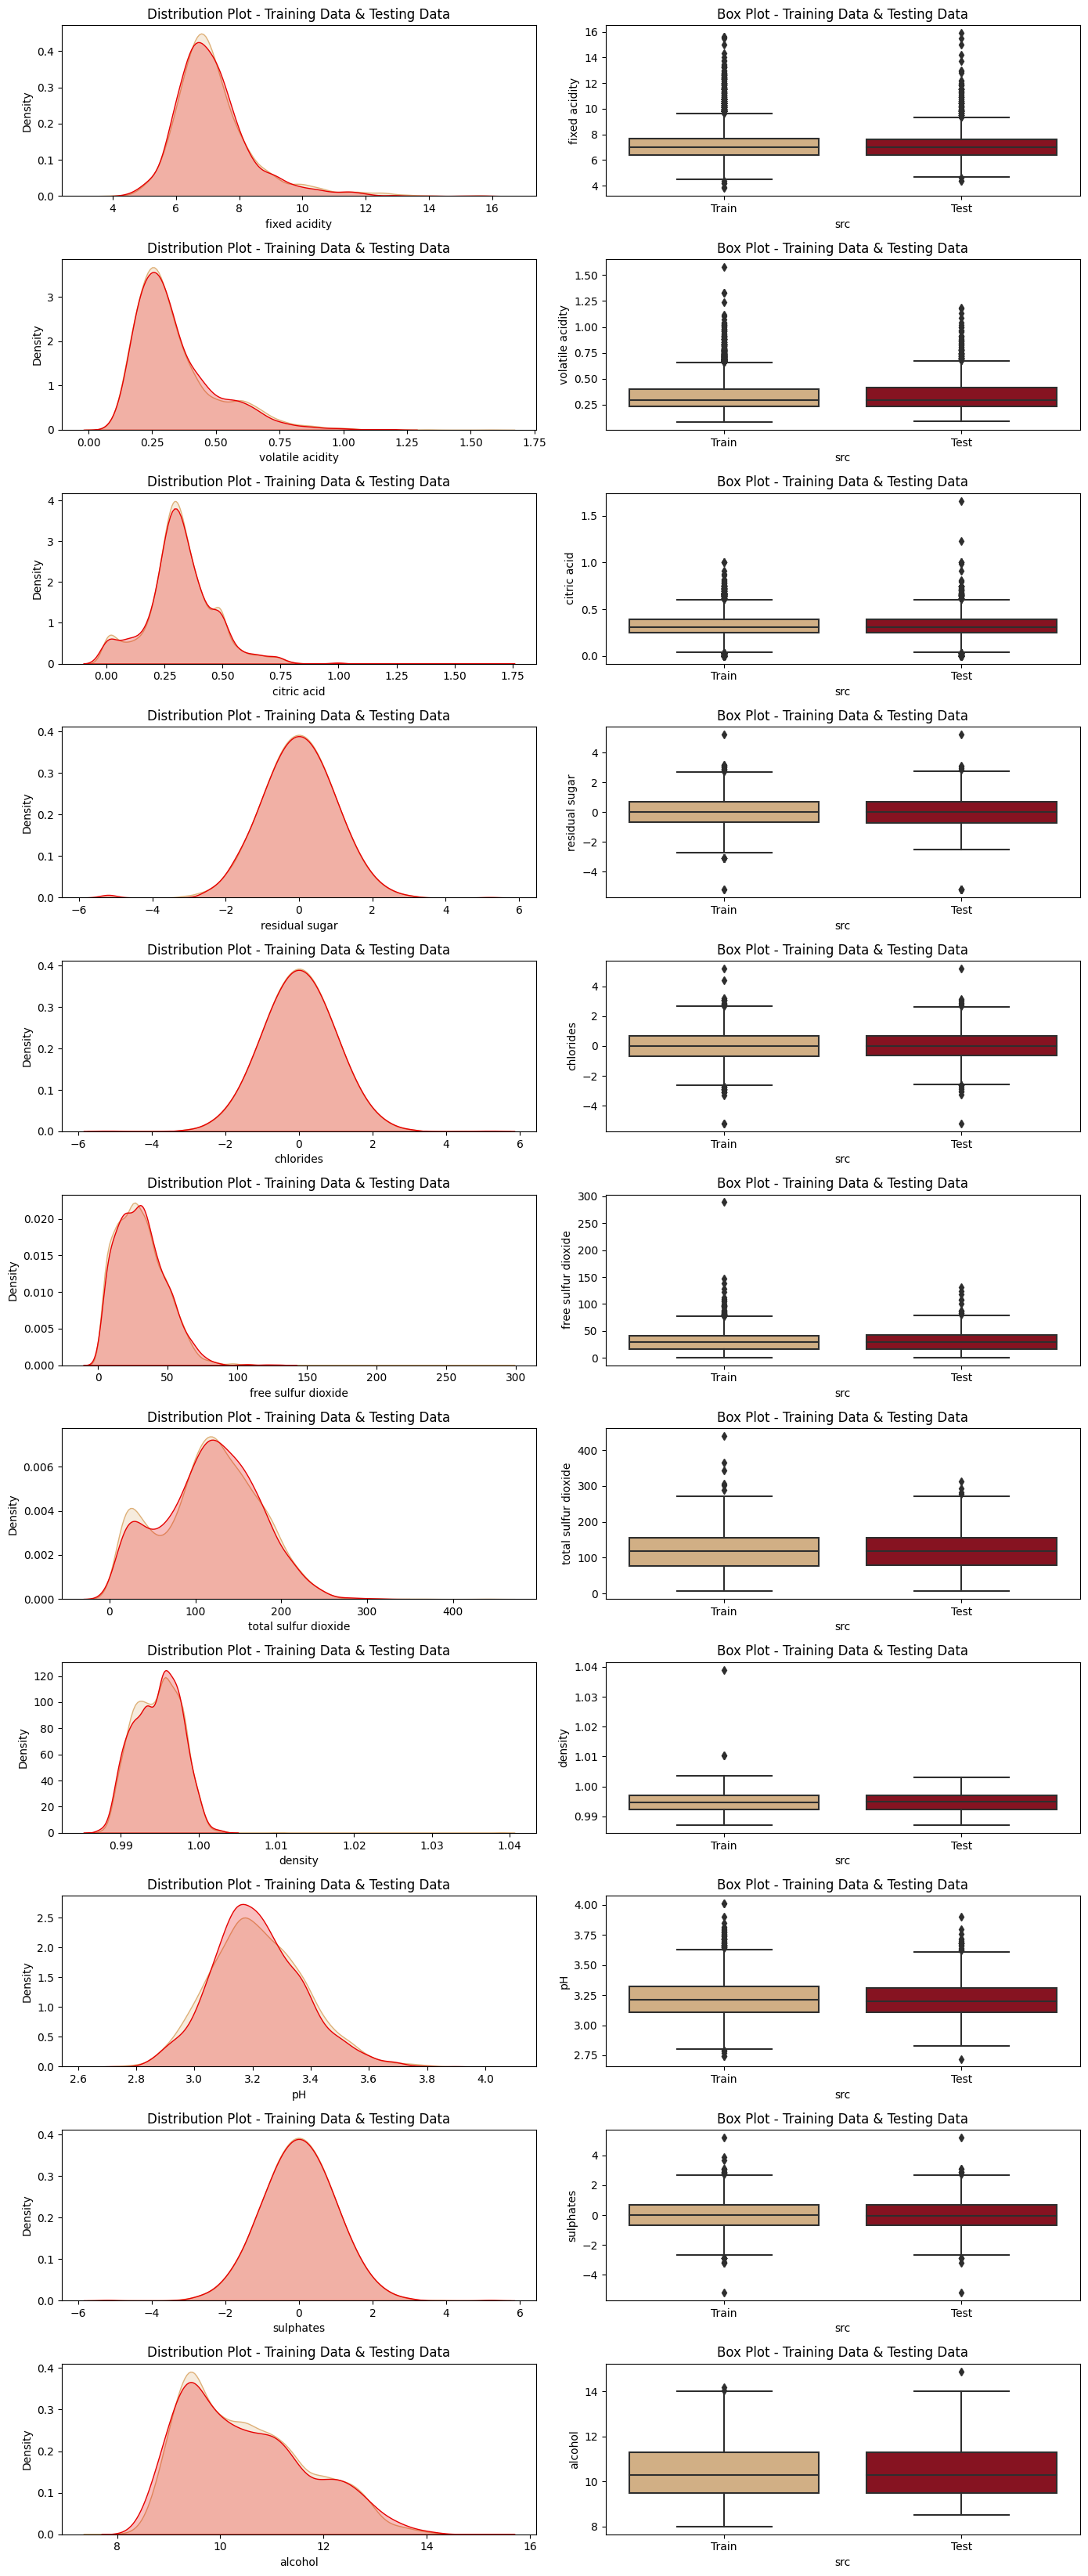

In [35]:
ncols = 2
cont_features=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

nrows = len(cont_features)
df_temp=pd.concat([df_train.assign(src='Train'),df_test.assign(src='Test')])
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3*nrows))

for r in range(nrows):
    row = cont_features[r]
   
    sns.kdeplot(x=df_train[row], ax=axes[r,0], color='#DEB078', label='Train data' , fill =True )
    sns.kdeplot(x=df_test[row], ax=axes[r,0], color='#e60000', label='Test data', fill =True)
    
    sns.boxplot(data=df_temp, y=row,x='src' ,ax=axes[r,1],palette=['#DEB078','#990012','#e60000'])


    axes[r,0].title.set_text("Distribution Plot - Training Data & Testing Data")
    axes[r,1].title.set_text("Box Plot - Training Data & Testing Data")
fig.tight_layout()
plt.show()

In [36]:
from scipy.stats import zscore
df_zscores = pd.concat((df_train.drop('target',axis =1), df_test.drop('wine_ID',axis =1)), axis =0).apply(zscore)
print("Sample z-scores by feature:\n")
df_zscores.head()

Sample z-scores by feature:



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type
0,-0.011808,-1.091373,-0.403514,0.531170,0.381627,0.590188,1.915432,0.634785,1.004505,0.317061,-0.328521,-0.571367
1,0.065333,-0.726906,-0.059414,-0.249694,-2.633240,0.815565,-0.632451,-1.779802,-0.985856,-1.708280,2.019251,-0.571367
2,1.299582,-1.273607,1.179346,-2.004149,-1.623370,-1.381861,-1.623295,-0.699241,-1.918838,-2.023406,-0.496219,-0.571367
3,-0.937495,-1.030629,-0.197054,0.865469,-0.239047,0.139434,-0.313966,0.221237,-0.612663,-1.460952,-1.083162,-0.571367
4,0.219614,-0.909139,0.147046,-0.094900,-0.747789,0.139434,0.163762,-0.799293,-0.737061,-0.167147,0.509969,-0.571367


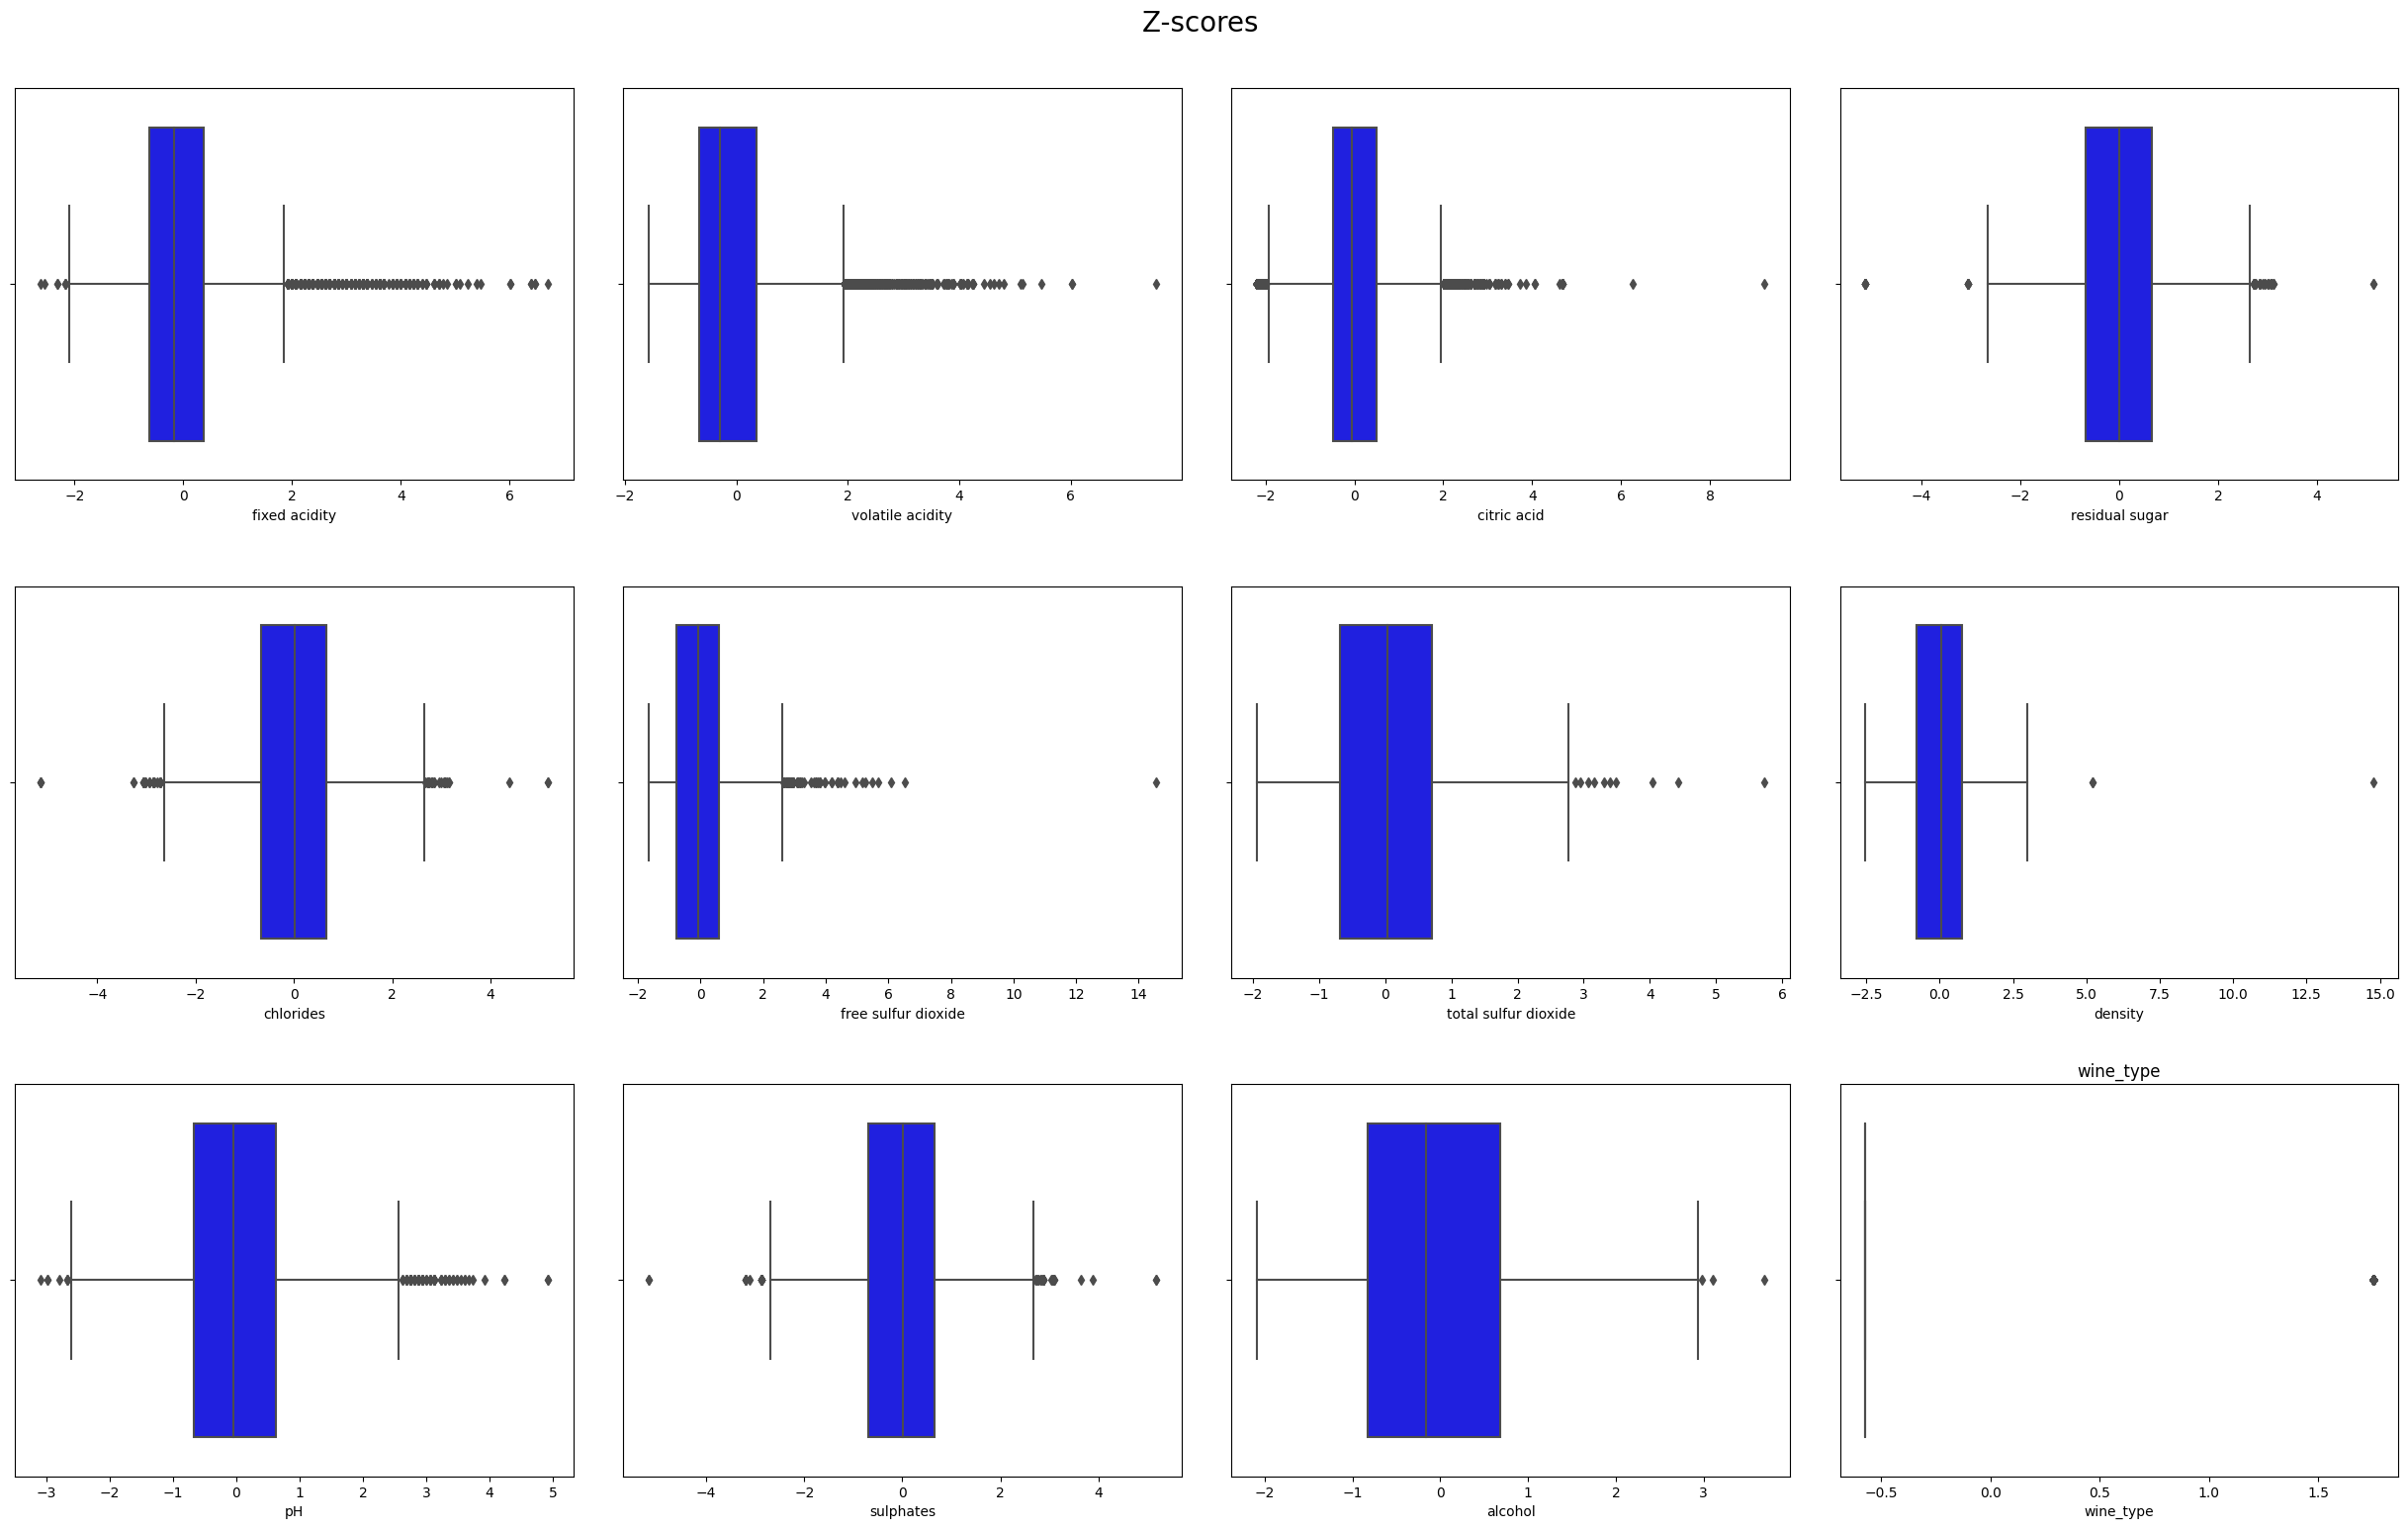

In [37]:
fig,ax = plt.subplots(int(np.ceil(12/4)),4,figsize = (25,16))
ax = np.ravel(ax)

for i,col in enumerate(df_zscores.columns):
    sns.boxplot(ax = ax[i], x = df_zscores[col], color= "blue")
ax[i].set_title(f"{col}")
fig.suptitle("Z-scores ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

By looking at the above graphs we have a number of columns with outliers:
* fixed acidity
* residual sugar
* chlorides
* ph
* sulphates

In [38]:
outliers = ['fixed acidity', 'residual sugar', 'chlorides','pH' ,'sulphates']

We are going to use a RobustScaler to try to remove outliers from these columns.

In [39]:
# Transformation du Dataset de train
scaler = RobustScaler()
quant_df = scaler.fit_transform(df_train[outliers])
df_train[outliers] = quant_df

# Transformation du Dataset de train
scaler = QuantileTransformer(output_distribution="normal")
quant_df = scaler.fit_transform(df_test[outliers])
df_test[outliers] = quant_df

In [40]:
df_zscores = pd.concat((df_train.drop('target',axis =1), df_test.drop('wine_ID',axis =1)), axis =0).apply(zscore)
print("Sample z-scores by feature:\n")
df_zscores.head()

Sample z-scores by feature:



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type
0,0.026810,-1.091373,-0.403514,0.471103,0.350126,0.590188,1.915432,0.634785,0.910415,0.282393,-0.328521,-0.571367
1,0.102378,-0.726906,-0.059414,-0.222531,-2.352491,0.815565,-0.632451,-1.779802,-0.872934,-1.528123,2.019251,-0.571367
2,1.311454,-1.273607,1.179346,-1.780997,-1.447213,-1.381861,-1.623295,-0.699241,-1.708879,-1.809824,-0.496219,-0.571367
3,-0.879997,-1.030629,-0.197054,0.768057,-0.206264,0.139434,-0.313966,0.221237,-0.538556,-1.307028,-1.083162,-0.571367
4,0.253512,-0.909139,0.147046,-0.085029,-0.662316,0.139434,0.163762,-0.799293,-0.650016,-0.150456,0.509969,-0.571367


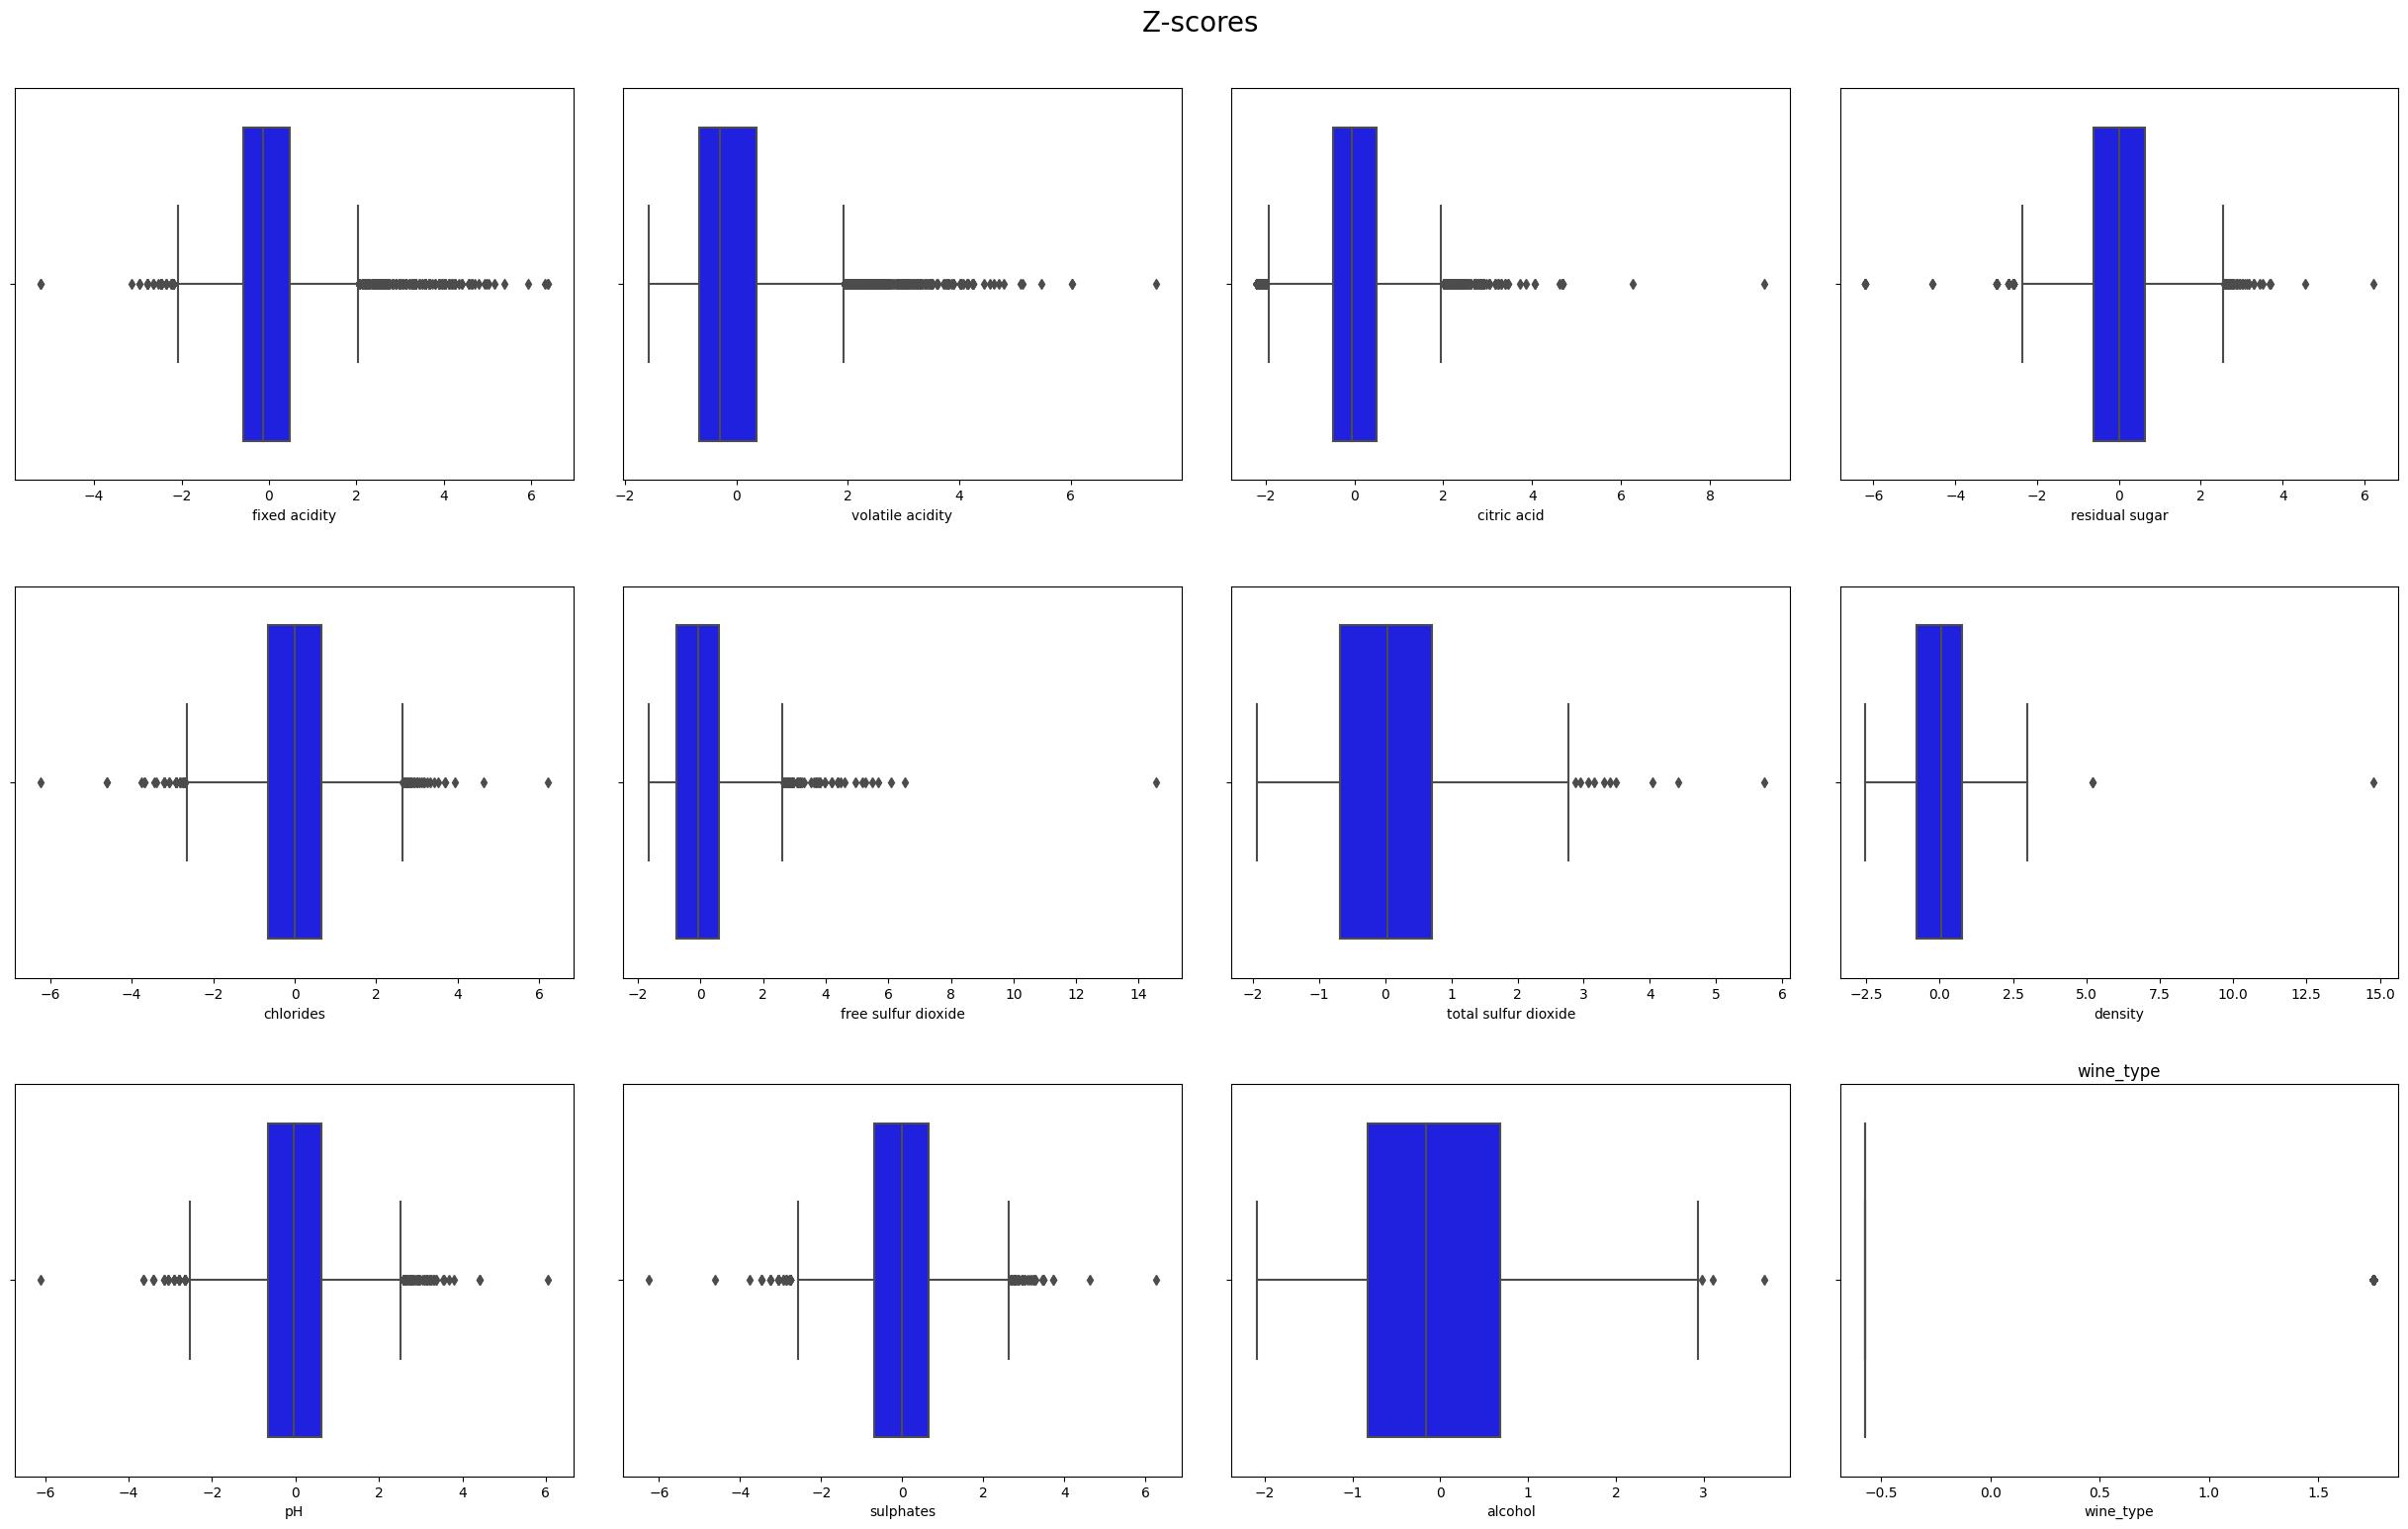

In [41]:
fig,ax = plt.subplots(int(np.ceil(12/4)),4,figsize = (25,16))
ax = np.ravel(ax)

for i,col in enumerate(df_zscores.columns):
    sns.boxplot(ax = ax[i], x = df_zscores[col], color= "blue")
ax[i].set_title(f"{col}")
fig.suptitle("Z-scores ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In [42]:
pca_cols = ["density","alcohol",'free sulfur dioxide', 'total sulfur dioxide']
pca_ = PCA(n_components=2 ,whiten= False)
df_train_pca = df_train.copy()
df_test_pca = df_test.copy()
df_train_pca[["pca_1","pca_2"]] = pca_.fit_transform(df_train[pca_cols])
print(f'Explained variance ratio for train dataset:{np.sum(pca_.explained_variance_ratio_)}')

df_test_pca[["pca_1", "pca_2"]] = pca_.fit_transform(df_test[pca_cols])

df_train_pca.drop(columns = pca_cols, inplace = True)
df_test_pca.drop(columns = pca_cols, inplace = True)

print(f'Explained variance ratio for test dataset:{np.sum(pca_.explained_variance_ratio_)}')


Explained variance ratio for train dataset:0.9996374762338599
Explained variance ratio for test dataset:0.9995896816001048


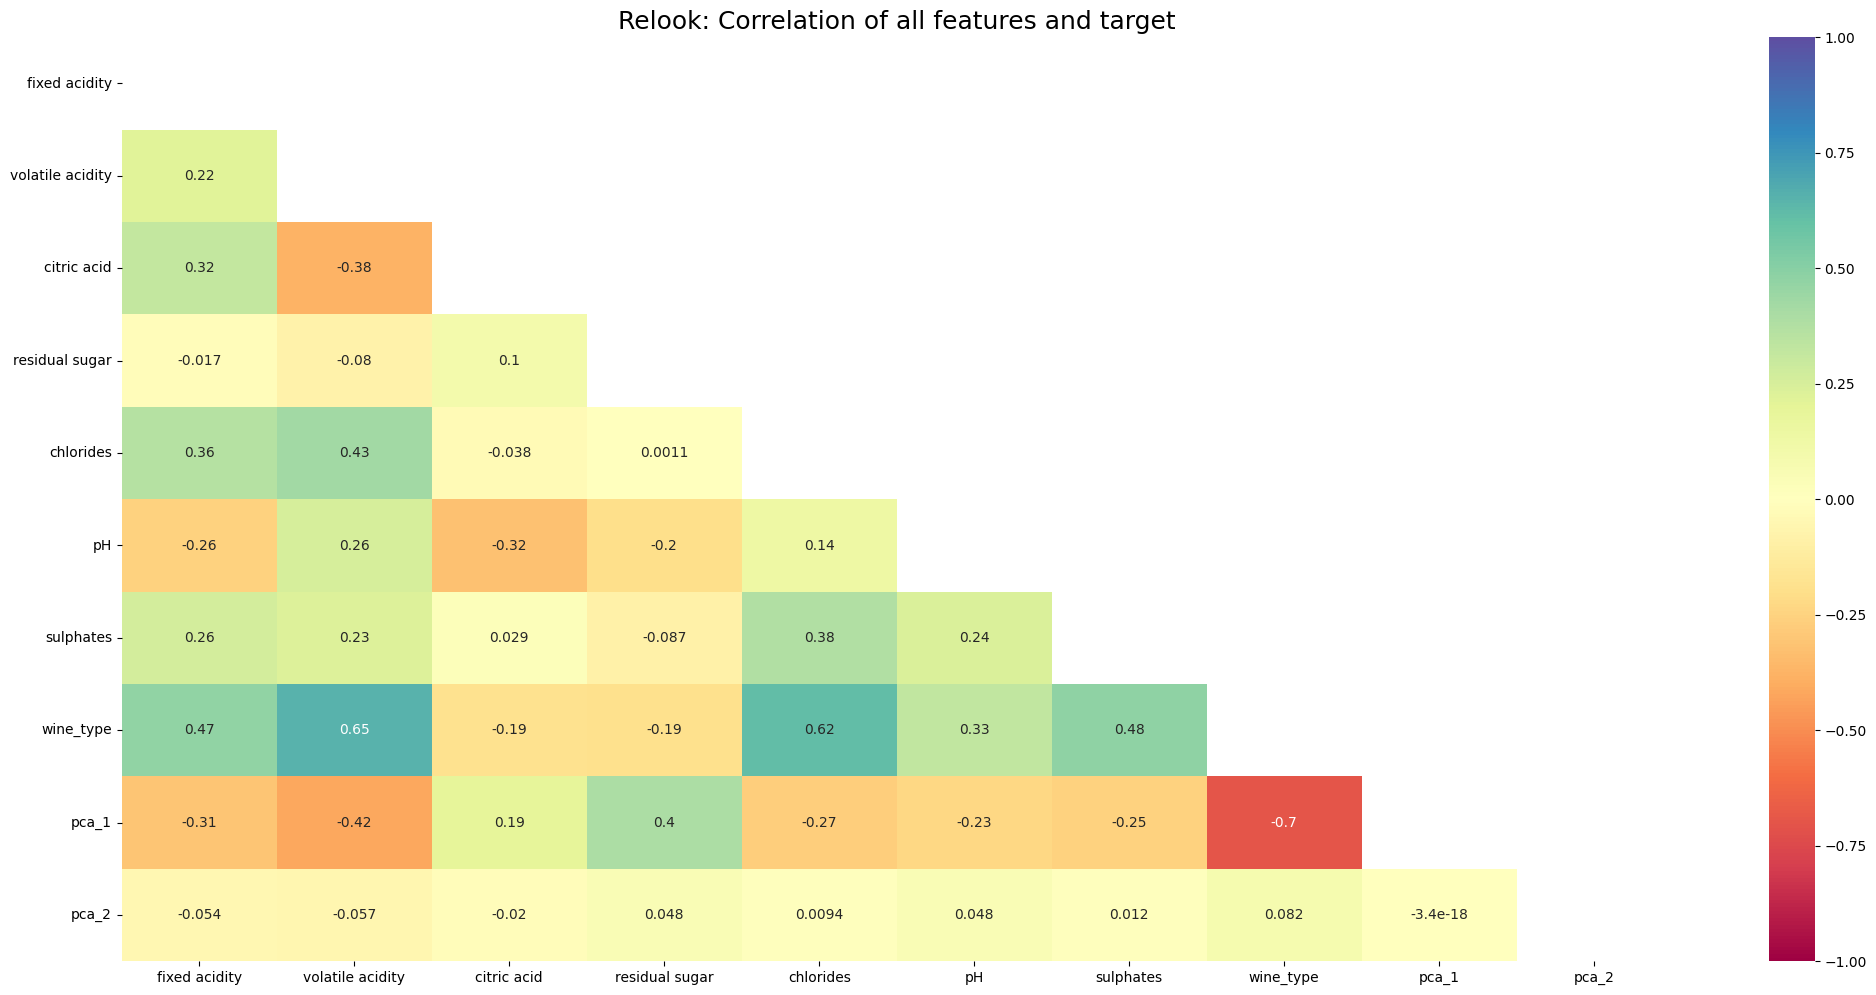

In [43]:
plt.figure(figsize = (25,12))
corr = pd.concat((df_train_pca.drop('target',axis =1), df_test_pca.drop('wine_ID', axis = 1)), axis =0).corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Relook: Correlation of all features and target", fontsize= 18)
plt.show()

Avec l'utilisation de la PCA on a quand même bien réduit les corrélations dans le dataset. 

A présent testons l'efficacité des modèles sur les différents dataset.

In [44]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = list(range(1,13))
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
max_samples = list(np.arange(0.1,1, 0.1))
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_samples': max_samples          
              }

In [45]:
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)
#rf_random.fit(df_train_pca.drop('target',axis=1), df_train_pca['target'])

In [46]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(df_train_pca.drop('target',axis=1),
                                                                            df_train_pca['target'],
                                                                            shuffle=False,
                                                                            test_size=0.2)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_split, y_train_split)
base_accuracy = evaluate(base_model, X_test_split, y_test_split)
best_random = RandomForestRegressor(**best_params)
best_random.fit(X_train_split, y_train_split)
random_accuracy = evaluate(best_random, X_test_split, y_test_split)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 0.5064 degrees.
Accuracy = 91.17%.
Model Performance
Average Error: 0.4849 degrees.
Accuracy = 91.57%.
Improvement of 0.44%.


In [47]:
best_random.fit(df_train_pca.drop('target',axis=1),df_train_pca['target'])
results = best_random.predict(df_test_pca.drop('wine_ID', axis = 1))
df_res_ = pd.DataFrame({'target':results, 'wine_ID':df_test['wine_ID']})
df_res.to_csv('results.csv', index = False)

In [48]:
EPOCHS= 10000
lgb_classifier_params ={
    'objective': 'multiclassova',#multiclassova multiclass
    "metric":"multi_logloss", 
    "boosting": "gbdt",#"dart",gbdt
    'num_class': 6,
    'is_unbalanced' : True,
    # 'lambda_l1': 1.0050418664783436e-08, 
    # 'lambda_l2': 9.938606206413121,
    # 'num_leaves': 44,
    'feature_fraction': 0.8247273276668773,
    'bagging_fraction': 0.5842711778104962,
    # 'bagging_freq': 6,
    # 'min_data_in_leaf': 134,
    # 'min_child_samples': 70,
    # 'max_depth': 8,
    'class_weight': 'balanced', #'balanced',     weights     
    'n_estimators':EPOCHS,
    'learning_rate':0.01,
    'device':'cpu'}

In [49]:
def kappa_score(dy_true, dy_pred):
    pred_labels = dy_pred.reshape(len(np.unique(dy_true)),-1).argmax(axis=0)
    
    ks = cohen_kappa_score(dy_true, pred_labels, weights ='quadratic' )
    is_higher_better = True

    return "kappa_score", ks, is_higher_better

In [50]:
model= lgb.LGBMClassifier(**lgb_classifier_params)

X = df_train_pca.drop(['target'],axis =1)
y = df_train_pca['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_s = X_train.copy(deep= True)
X_test_s = X_test.copy(deep= True)
test_temp = df_test_pca.drop('wine_ID', axis = 1).copy(deep= True)
y_train_s = y_train.copy(deep= True)
X_temp = X.copy(deep = True)

model.fit(X_train_s,y_train_s,
          eval_set=[(X_test_s,y_test)],
          eval_metric=kappa_score,
          callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])

y_preds = model.predict_proba(X_test_s)
trn_preds_base = model.predict_proba(X_temp)
test_base = model.predict_proba(test_temp)

score_trn =cohen_kappa_score(y, trn_preds_base.argmax(axis =1), weights ='quadratic' )
score_val = cohen_kappa_score(y_test, y_preds.argmax(axis =1), weights ='quadratic' )

print("\nTrn kappa:",score_trn)
print("Val kappa:",score_val)
print("Val logloss", log_loss(y,trn_preds_base))

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 1.41543	valid_0's kappa_score: 0.496555

Trn kappa: 0.11393166451704329
Val kappa: 0.09064694555614283
Val logloss 1.1761087860426775


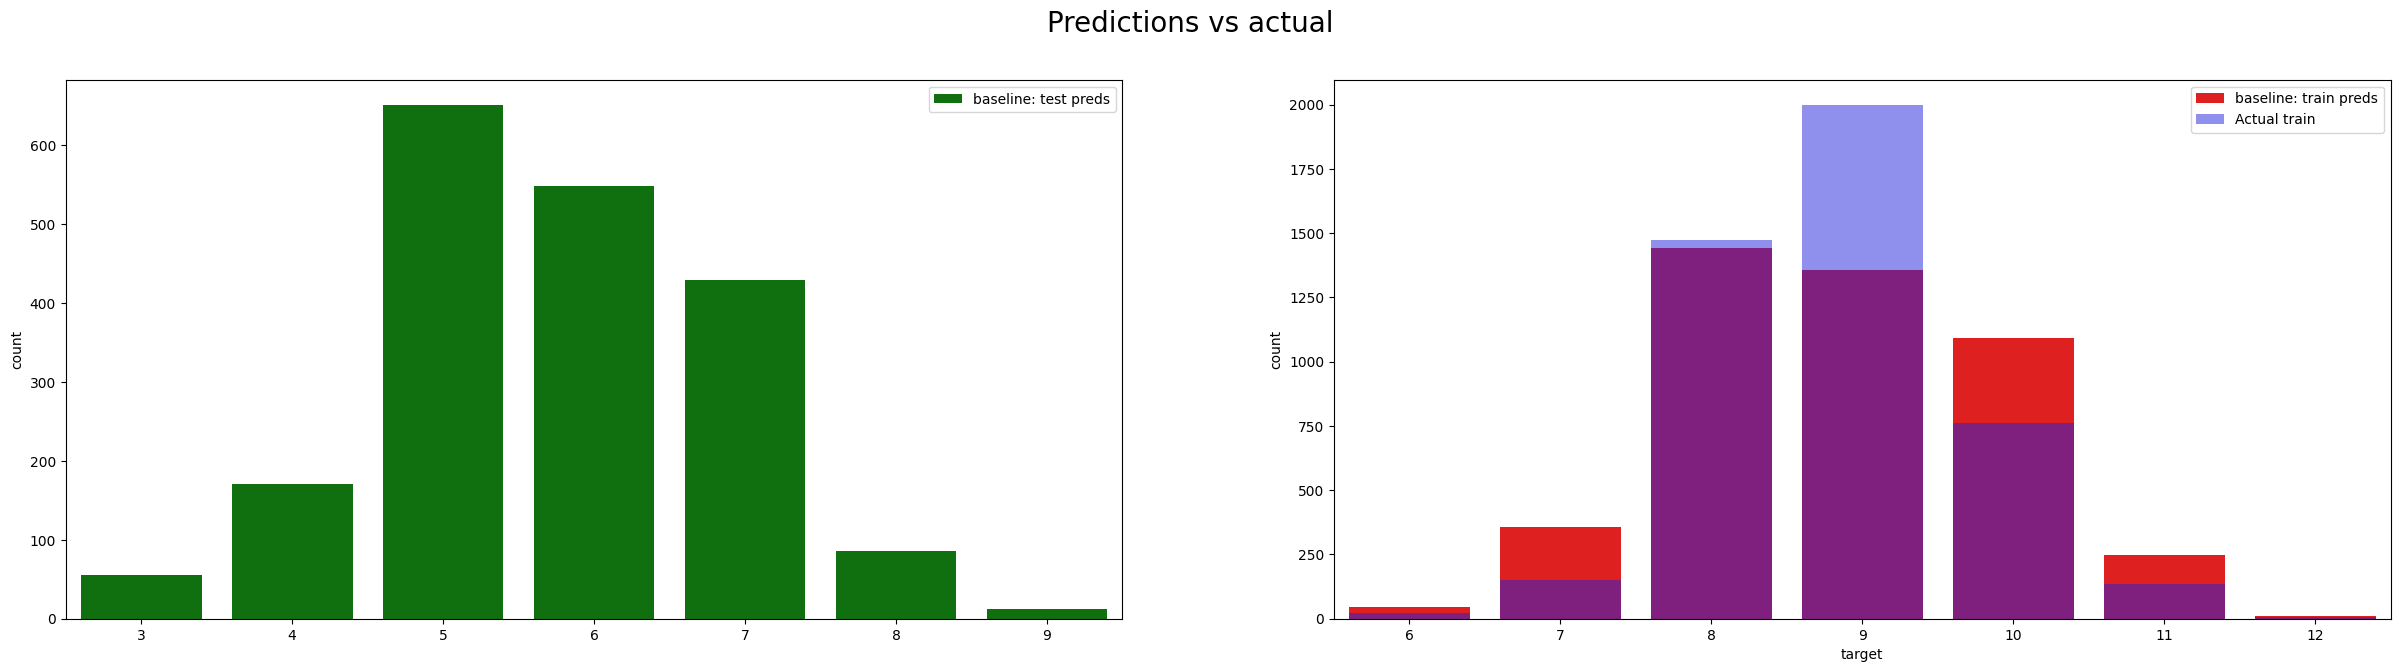

In [51]:
fig, ax = plt.subplots(1,2, figsize = (30,7))
sns.countplot(x =test_base.argmax(axis =1)+3, label = f"baseline: test preds", color ='green', ax= ax[0])
sns.countplot(x =trn_preds_base.argmax(axis =1)+3, label = f"baseline: train preds", color ='red', ax= ax[1])
sns.countplot(x =y+3, label = f"Actual train",alpha =0.5, color ='blue', ax= ax[1])
ax[0].legend()
ax[1].legend()
plt.suptitle("Predictions vs actual", fontsize = 20)
plt.show()

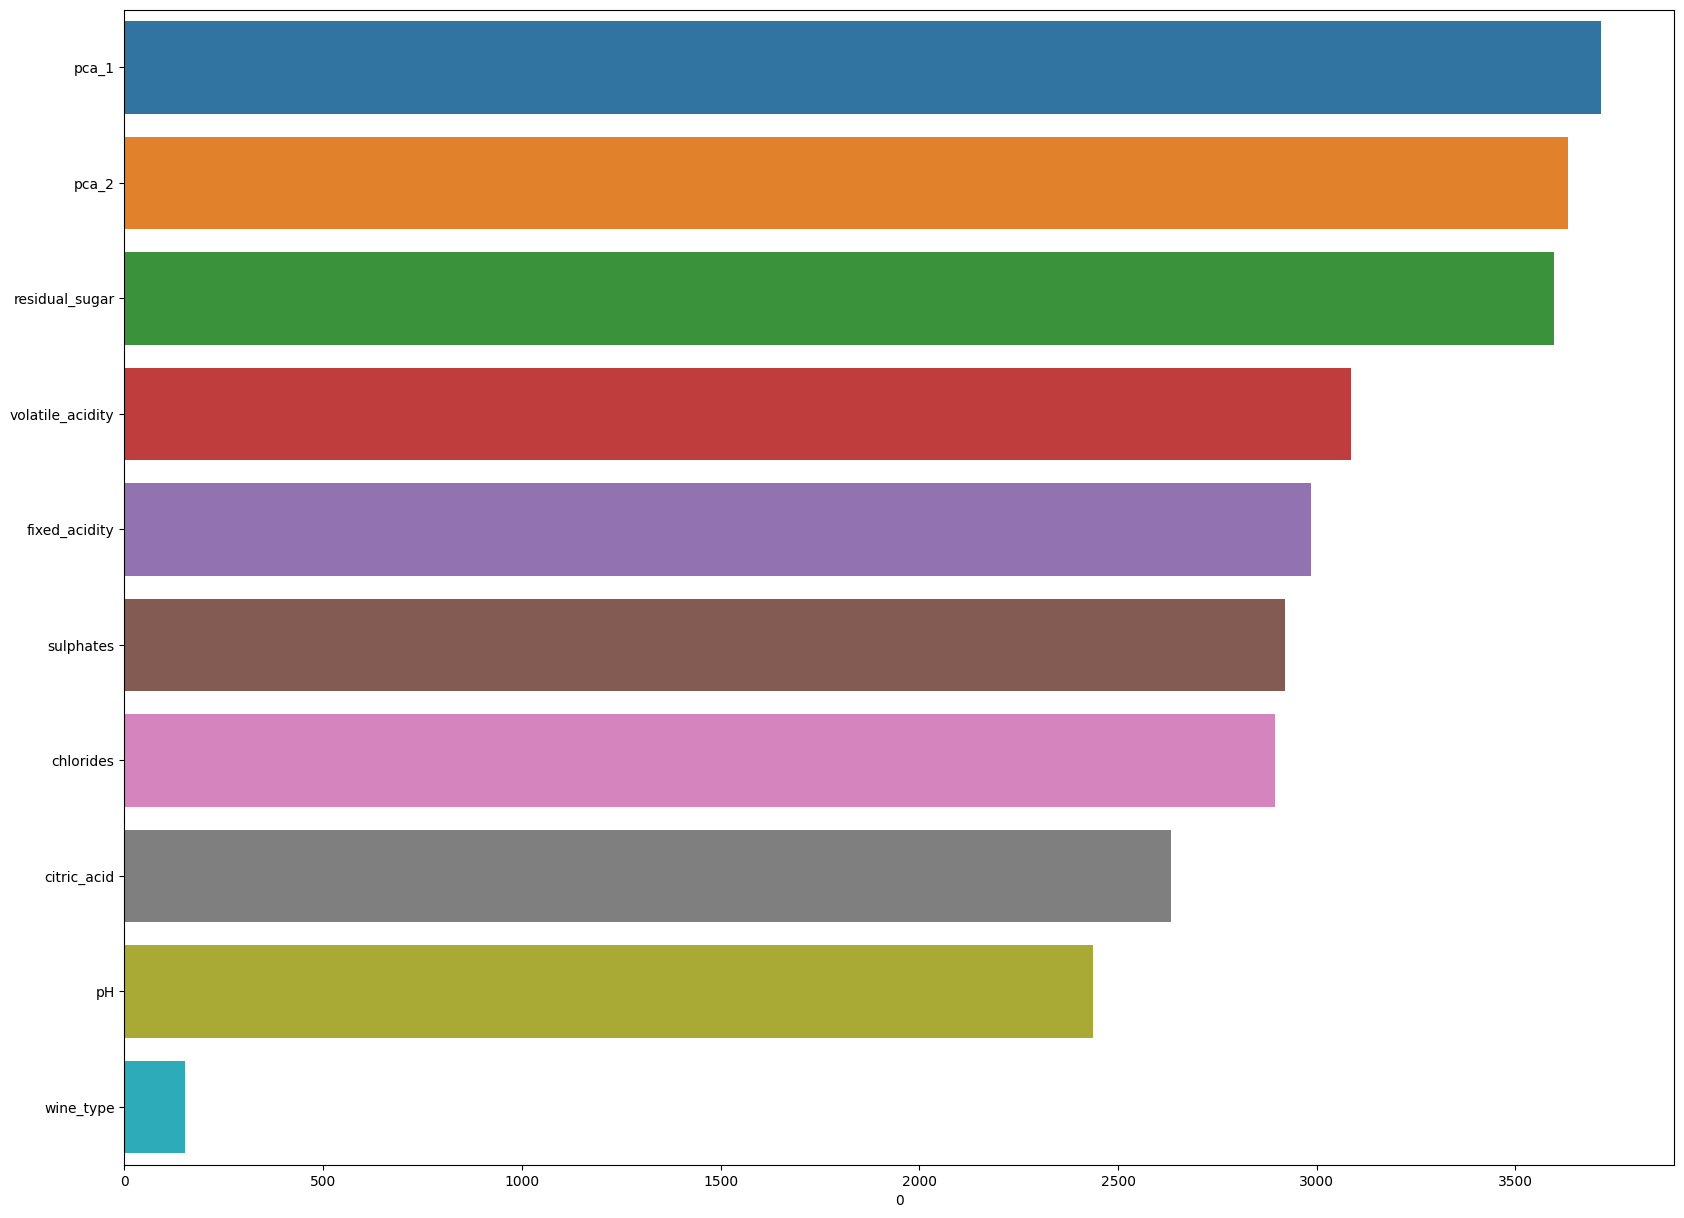

In [52]:
importances = pd.DataFrame(data = model.feature_importances_, index = model.feature_name_).sort_values(ascending = False , by =0)

plt.figure(figsize = (20,15))
sns.barplot(x = importances[0], y= importances.index)
plt.show()

In [53]:
weights = (df_train_pca['target'] - 3).value_counts().sort_index()
weights = weights / len(df_train_pca)
weights= weights.to_dict()
print(f"Catboost class weights:\n {weights}")

Catboost class weights:
 {0: 0.005058280184737189, 1: 0.03320870903892677, 2: 0.3243897074994502, 3: 0.439190675170442, 4: 0.16736309654717396, 5: 0.02968990543215307, 6: 0.0010996261271167802}


In [54]:
xgb_params_classifier = { 
    'objective' : "multi:softproba",
    'num_class' : 6,
    'n_estimators' : EPOCHS, 
    #'early_stopping_rounds' :30,
    #'custom_metric':kappa_score,
    #'scale_pos_weight':weights
             }

xgb_params_regressor = {
    'objective': 'reg:squarederror',
    'n_estimators': EPOCHS
}

lgb_regressor_params = {
    'objective': 'regression',
    "metric": "mse",
    'boosting': 'gbdt',
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'n_estimators': EPOCHS,
    'learning_rate': 0.01,
    'bagging_fraction': 0.5842711778104962,
    'feature_fraction': 0.8247273276668773,
    'device': 'cpu'
}

cat_params = {'iterations':EPOCHS,
              'class_weights' : weights,
              'learning_rate': 0.01,
              'loss_function':'MultiClass'
             }
cat_params_regression = {
    'iterations': EPOCHS,
    'learning_rate': 0.01,
    'loss_function': 'RMSE'
}

ET_params = {'max_depth':6, 'num_iterations':EPOCHS}
RF_params = best_params
RF_params_class = RF_params.copy()
RF_params['criterion'] = 'gini'
models = {
    "LinearReg": LinearRegression(),
    "LogisticRegression": LogisticRegression(max_iter = EPOCHS, ),
    'Lasso' : Lasso(max_iter= EPOCHS),
    "SVC":SVC(probability=True, kernel = "rbf",class_weight='balanced',max_iter = EPOCHS),
    'RidgeClassifier': RidgeClassifier(),
    'Ridge':Ridge(), 
    "lightgbm": lgb.LGBMClassifier(**lgb_classifier_params), 
    "xgboost": xgb.XGBClassifier(**xgb_params_classifier), 
    "catboost": cat.CatBoostClassifier(**cat_params),
    "lightgbm_reg": lgb.LGBMRegressor(**lgb_regressor_params), 
    "xgboost_reg": xgb.XGBRegressor(**xgb_params_regressor), 
    "catboost_reg": cat.CatBoostRegressor(**cat_params_regression),
    "ExtraTreeClassifier": ExtraTreesClassifier(),
    "RandomForestClassifier":RandomForestClassifier(**RF_params),
    "RandomForestRegression":RandomForestRegressor(**RF_params)
}

In [55]:
outliers = ['fixed acidity', 'residual sugar', 'chlorides','pH' ,'sulphates']
OUTLIERS = True

DISTRIBUTION = True
non_dist_cols = ['sulphates', 'residual sugar', 'chlorides']

SCALING = True 
scaled_cols = df_train_pca.drop(['wine_type', 'target'], axis = 1).columns

SMOTE_over = False

def Scaling(X_train_split: pd.DataFrame(), 
            X_test_split: pd.DataFrame(),
            y_train: pd.DataFrame() = None,
            SMOTE_over: bool = SMOTE_over,
            OUTLIERS: bool = OUTLIERS,
            SCALING: bool  = SCALING,
           ) : 
    
    """Scaling and Sampling Helper function: 
        Scales and oversamples training and validation dataframes 
    
    :param 
        X_train: pandas dataframe of training data , less target values
        X_test: pandas dataframe of validation data , less target values
        test_df: pandas dataframe of test data , less target values
        y_train: pandas dataframe or series of target training values
        X: pandas dataframe of training and validation data, less target values
        
    :return: scaled input paramaters as pandas dataframes 

    """
    
    X_train_s = X_train_split.copy(deep = True)
    X_test_s = X_test_split.copy(deep = True)
    
    if OUTLIERS and len(outliers)>0:
        #Scale outliers: see boxplots
        scaler = RobustScaler()
        X_train_s[outliers] = scaler.fit_transform(X_train_s[outliers])
        X_test_s[outliers]  = scaler.transform(X_test_s[outliers])
        
    if DISTRIBUTION:
        scaler = QuantileTransformer(output_distribution="normal")
        X_train_s[non_dist_cols] = scaler.fit_transform(X_train_s[non_dist_cols])
        X_test_s[non_dist_cols]  = scaler.transform(X_test_s[non_dist_cols])
            
    if SCALING: 
        X_train_s[scaled_cols] = StandardScaler().fit_transform(X_train_s[scaled_cols])
        X_test_s[scaled_cols]  = StandardScaler().fit_transform(X_test_s[scaled_cols])
        
    if SMOTE_over:
        smt = SMOTE()
        y_trn_s = y_train.copy(deep=True)
        X_train_s, y_trn_s = smt.fit_resample(X_train_s, y_trn_s)
        
        X_train_s = pd.DataFrame(X_train_s, columns = X_train_split.columns)
        y_trn_s = pd.Series(y_trn)
        return X_train_s, X_test_s, y_trn_s
    y_trn_s = y_train.copy(deep=True)
    return X_train_s, X_test_s, y_trn_s

X = df_train_pca.drop('target', axis=1).copy()
y = df_train_pca['target'].copy() - 3



logs = {name: {i: [] for i in range(5)} for name in models}
dict_results = {name: {i:{metrics:{'train':[], 'test':[]} for metrics in ['log_loss', 'mse', 'accuracy', 'r2_score', 'cohen_kappa']} for i in range(5)} for name in models }

for fold, (train_idx,val_idx) in tqdm(enumerate(KFold().split(X,y))):
    X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
    X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
    for name, model in tqdm(models.items()):
        try:
            if name in ["LogisticRegression",'Ridge', "SVC"]:
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)
                X_test_s  = scaler.transform(X_test)
                y_train_s = y_train.copy()
            else:
                X_train_s, X_test_s, y_train_s = Scaling(X_train, X_test, y_train)
            
            if 'catboost' in name:
                model.fit(X_train_s, y_train_s, verbose = False)
            else:
                model.fit(X_train_s, y_train_s)
            y_preds_train = model.predict(X_train_s)
            y_preds_test = model.predict(X_test_s)

            mse_train = mean_squared_error(y_train_s, y_preds_train)
            mse_test = mean_squared_error(y_test, y_preds_test)
            
            r2_train = r2_score(y_train_s, y_preds_train)
            r2_test = r2_score(y_test, y_preds_test)
            
            
            if name not in ['lightgbm_reg', 'xgboost_reg', 'catboost_reg', 'RidgeClassifier']:
                y_proba_train = model.predict_proba(X_train_s)
                y_proba_test = model.predict_proba(X_test_s)
                log_loss_train = log_loss(y_train_s, y_proba_train, labels = [0, 1, 2, 3, 4, 5, 6])
                log_loss_test = log_loss(y_test, y_proba_test, labels = [0, 1, 2, 3, 4, 5, 6])
                accuracy_train = accuracy_score(y_train_s, y_preds_train)
                accuracy_test = accuracy_score(y_test, y_preds_test)
                ck_train = cohen_kappa_score(y_train_s, y_preds_train)
                ck_test = cohen_kappa_score(y_test, y_preds_test)


                dict_results[name][fold]['log_loss']['train'].append(log_loss_train)
                dict_results[name][fold]['log_loss']['test'].append(log_loss_test)

                dict_results[name][fold]['accuracy']['train'].append(accuracy_train)
                dict_results[name][fold]['accuracy']['test'].append(accuracy_test)
                
                dict_results[name][fold]['cohen_kappa']['train'].append(ck_train)
                dict_results[name][fold]['cohen_kappa']['test'].append(ck_test)
                
                

            dict_results[name][fold]['mse']['train'].append(mse_train)
            dict_results[name][fold]['mse']['test'].append(mse_test)
            dict_results[name][fold]['r2_score']['train'].append(r2_train)
            dict_results[name][fold]['r2_score']['test'].append(r2__test)
        except Exception as e:
            logs[name][fold].append(e)
    

dict_results

logs

X = df_train_pca.drop('target', axis=1).copy()
y = df_train_pca['target'].copy() - 3

logs_smt = {name: {i: [] for i in range(5)} for name in models}
dict_results_smt = {name: {i:{metrics:{'train':[], 'test':[]} for metrics in ['log_loss', 'mse', 'accuracy', 'r2_score', 'cohen_kappa']} for i in range(5)} for name in models }

for fold, (train_idx,val_idx) in tqdm(enumerate(KFold().split(X,y))):
    X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
    X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
    for name, model in tqdm(models.items()):
        try:
            if name in ["LogisticRegression",'Ridge', "SVC"]:
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)
                X_test_s  = scaler.transform(X_test)
                y_train_s = y_train.copy()
            else:
                X_train_s, X_test_s, y_train_s = Scaling(X_train, X_test, y_train, SMOTE_over = True)
            
            if 'catboost' in name:
                model.fit(X_train_s, y_train_s, verbose = False)
            else:
                model.fit(X_train_s, y_train_s)
            y_preds_train = model.predict(X_train_s)
            y_preds_test = model.predict(X_test_s)

            mse_train = mean_squared_error(y_train_s, y_preds_train)
            mse_test = mean_squared_error(y_test, y_preds_test)
            
            r2_train = r2_score(y_train_s, y_preds_train)
            r2_test = r2_score(y_test, y_preds_test)
            
            
            if name not in ['lightgbm_reg', 'xgboost_reg', 'catboost_reg', 'RidgeClassifier']:
                y_proba_train = model.predict_proba(X_train_s)
                y_proba_test = model.predict_proba(X_test_s)
                log_loss_train = log_loss(y_train_s, y_proba_train, labels = [0, 1, 2, 3, 4, 5, 6])
                log_loss_test = log_loss(y_test, y_proba_test, labels = [0, 1, 2, 3, 4, 5, 6])
                accuracy_train = accuracy_score(y_train_s, y_preds_train)
                accuracy_test = accuracy_score(y_test, y_preds_test)
                ck_train = cohen_kappa_score(y_train_s, y_preds_train)
                ck_test = cohen_kappa_score(y_test, y_preds_test)


                dict_results_smt[name][fold]['log_loss']['train'].append(log_loss_train)
                dict_results_smt[name][fold]['log_loss']['test'].append(log_loss_test)

                dict_results_smt[name][fold]['accuracy']['train'].append(accuracy_train)
                dict_results_smt[name][fold]['accuracy']['test'].append(accuracy_test)
                
                dict_results_smt[name][fold]['cohen_kappa']['train'].append(ck_train)
                dict_results_smt[name][fold]['cohen_kappa']['test'].append(ck_test)
                
                

            dict_results_smt[name][fold]['mse']['train'].append(mse_train)
            dict_results_smt[name][fold]['mse']['test'].append(mse_test)
            dict_results_smt[name][fold]['r2_score']['train'].append(r2_train)
            dict_results_smt[name][fold]['r2_score']['test'].append(r2__test)
        except Exception as e:
            logs_smt[name][fold].append(e)
    

In [56]:
X = df_train_pca.drop('target', axis=1).copy()
y = df_train_pca['target'].copy() - 3
y_reg = df_train_pca['target'].copy()

X_test = df_test_pca.drop('wine_ID', axis=1).copy()

results = {model: 0 for model in models}
dict_results_all = {name: {metrics:{'train':[], 'test':[]} for metrics in ['log_loss', 'mse', 'accuracy', 'r2_score', 'cohen_kappa']} for name in models }
logs_all = {name: [] for name in models}

for name, model in tqdm(models.items()):
    try:
        if name in [
            "LogisticRegression",
            "SVC",
            'RidgeClassifier',
            "lightgbm",
            "xgboost",
            "catboost",
            "ExtraTreeClassifier",
            "RandomForestClassifier",
        ]:
            if name in ["LogisticRegression",'Ridge', "SVC"]:
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X)
                X_test_s  = scaler.transform(X_test)
                y_train_s = y.copy()
            else:
                X_train_s, X_test_s, y_train_s = Scaling(X, X_test, y)
        else:
            if name in ["LogisticRegression",'Ridge', "SVC"]:
                    scaler = StandardScaler()
                    X_train_s = scaler.fit_transform(X)
                    X_test_s  = scaler.transform(X_test)
                    y_train_s = y_reg.copy()
            else:
                X_train_s, X_test_s, y_train_s = Scaling(X, X_test, y_reg)

        if 'catboost' in name:
            model.fit(X_train_s, y_train_s, verbose = False)
        else:
            model.fit(X_train_s, y_train_s)
            
        y_preds_train = model.predict(X_train_s)
        y_preds_test = model.predict(X_test_s)
        results[name] = y_preds_test
        
        mse_train = mean_squared_error(y_train_s, y_preds_train)
  
        r2_train = r2_score(y_train_s, y_preds_train)
  

        if name not in [
            "LinearReg",
            'Lasso',
            'Ridge',
            "lightgbm_reg",
            "xgboost_reg",
            "catboost_reg",
            "RandomForestRegression", 
            "RidgeClassifier"
        ]:
            y_proba_train = model.predict_proba(X_train_s)
            log_loss_train = log_loss(y_train_s, y_proba_train, labels = [0, 1, 2, 3, 4, 5, 6])
            accuracy_train = accuracy_score(y_train_s, y_preds_train)
            ck_train = cohen_kappa_score(y_train_s, y_preds_train)
        
            dict_results_all[name]['log_loss']['train'].append(log_loss_train)
            dict_results_all[name]['accuracy']['test'].append(accuracy_train)
            dict_results_all[name]['cohen_kappa']['train'].append(ck_train)


        dict_results_all[name]['mse']['train'].append(mse_train)
        dict_results_all[name]['r2_score']['train'].append(r2_train)
    except Exception as e:
        print(e)
        logs_all[name].append(e)

 27%|██▋       | 4/15 [00:09<00:30,  2.78s/it]

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 60%|██████    | 9/15 [04:02<03:55, 39.25s/it]

[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


100%|██████████| 15/15 [04:58<00:00, 19.93s/it]

The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'friedman_mse', 'absolute_error', 'squared_error'}. Got 'gini' instead.


In [57]:
import pickle

with open('dict_results_all.pkl', 'wb') as fp:
    pickle.dump(dict_results_all, fp)
    
with open('logs_all.pkl', 'wb') as fp:
    pickle.dump(logs_all, fp)
    
results['catboost'] = [note[0] for note in results['catboost']]
df_results = pd.DataFrame(results)
df_results[[
            "LogisticRegression",
            "SVC",
            'RidgeClassifier',
            "lightgbm",
            "xgboost",
            "catboost",
            "ExtraTreeClassifier",
            "RandomForestClassifier",
        ]] += 3
df_results.to_csv('results_multi.csv')

In [58]:
for model_name, model in models.items():
    filename = f"{model_name}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Saved {model_name} model to {filename}")

Saved LinearReg model to LinearReg.pkl
Saved LogisticRegression model to LogisticRegression.pkl
Saved Lasso model to Lasso.pkl
Saved SVC model to SVC.pkl
Saved RidgeClassifier model to RidgeClassifier.pkl
Saved Ridge model to Ridge.pkl
Saved lightgbm model to lightgbm.pkl
Saved xgboost model to xgboost.pkl
Saved catboost model to catboost.pkl
Saved lightgbm_reg model to lightgbm_reg.pkl
Saved xgboost_reg model to xgboost_reg.pkl
Saved catboost_reg model to catboost_reg.pkl
Saved ExtraTreeClassifier model to ExtraTreeClassifier.pkl
Saved RandomForestClassifier model to RandomForestClassifier.pkl
Saved RandomForestRegression model to RandomForestRegression.pkl


In [59]:
X = df_train_pca.drop('target', axis=1).copy()
y = df_train_pca['target'].copy() - 3
y_reg = df_train_pca['target'].copy()

X_test = df_test_pca.drop('wine_ID', axis=1).copy()

results = {model: 0 for model in models}
dict_results_all = {name: {metrics:{'train':[], 'test':[]} for metrics in ['log_loss', 'mse', 'accuracy', 'r2_score', 'cohen_kappa']} for name in models }
logs_all = {name: [] for name in models}

for name, model in tqdm(models.items()):
    try:
        if name in [
            "LogisticRegression",
            "SVC",
            'RidgeClassifier',
            "lightgbm",
            "xgboost",
            "catboost",
            "ExtraTreeClassifier",
            "RandomForestClassifier",
        ]:
            if name in ["LogisticRegression",'Ridge', "SVC"]:
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X)
                X_test_s  = scaler.transform(X_test)
                y_train_s = y.copy()
            else:
                X_train_s, X_test_s, y_train_s = Scaling(X, X_test, y)
        else:
            if name in ["LogisticRegression",'Ridge', "SVC"]:
                    scaler = StandardScaler()
                    X_train_s = scaler.fit_transform(X)
                    X_test_s  = scaler.transform(X_test)
                    y_train_s = y_reg.copy()
            else:
                X_train_s, X_test_s, y_train_s = Scaling(X, X_test, y_reg)

        if 'catboost' in name:
            model.fit(X_train_s, y_train_s, verbose = False)
        else:
            model.fit(X_train_s, y_train_s)
            
        y_preds_train = model.predict(X_train_s)
        y_preds_test = model.predict(X_test_s)
        results[name] = y_preds_test
        
        mse_train = mean_squared_error(y_train_s, y_preds_train)
  
        r2_train = r2_score(y_train_s, y_preds_train)
  

        if name not in [
            "LinearReg",
            'Lasso',
            'Ridge',
            "lightgbm_reg",
            "xgboost_reg",
            "catboost_reg",
            "RandomForestRegression", 
            "RidgeClassifier"
        ]:
            y_proba_train = model.predict_proba(X_train_s)
            log_loss_train = log_loss(y_train_s, y_proba_train, labels = [0, 1, 2, 3, 4, 5, 6])
            accuracy_train = accuracy_score(y_train_s, y_preds_train)
            ck_train = cohen_kappa_score(y_train_s, y_preds_train)
        
            dict_results_all[name]['log_loss']['train'].append(log_loss_train)
            dict_results_all[name]['accuracy']['test'].append(accuracy_train)
            dict_results_all[name]['cohen_kappa']['train'].append(ck_train)


        dict_results_all[name]['mse']['train'].append(mse_train)
        dict_results_all[name]['r2_score']['train'].append(r2_train)
    except Exception as e:
        print(e)
        logs_all[name].append(e)

 27%|██▋       | 4/15 [00:09<00:30,  2.80s/it]

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


 60%|██████    | 9/15 [04:04<03:57, 39.59s/it]

[LightGBM] [Warning] bagging_fraction is set=0.5842711778104962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5842711778104962
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8247273276668773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8247273276668773
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


100%|██████████| 15/15 [05:00<00:00, 20.04s/it]

The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'friedman_mse', 'absolute_error', 'squared_error'}. Got 'gini' instead.


In [60]:
import pickle

with open('dict_results_all_smote.pkl', 'wb') as fp:
    pickle.dump(dict_results_all, fp)
    
with open('logs_all_smote.pkl', 'wb') as fp:
    pickle.dump(logs_all, fp)
    
results['catboost'] = [note[0] for note in results['catboost']]
df_results = pd.DataFrame(results)
df_results[[
            "LogisticRegression",
            "SVC",
            'RidgeClassifier',
            "lightgbm",
            "xgboost",
            "catboost",
            "ExtraTreeClassifier",
            "RandomForestClassifier",
        ]] += 3
df_results.to_csv('results_multi_smote.csv')

In [61]:
for model_name, model in models.items():
    filename = f"{model_name}_smote.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Saved {model_name} model to {filename}")

Saved LinearReg model to LinearReg_smote.pkl
Saved LogisticRegression model to LogisticRegression_smote.pkl
Saved Lasso model to Lasso_smote.pkl
Saved SVC model to SVC_smote.pkl
Saved RidgeClassifier model to RidgeClassifier_smote.pkl
Saved Ridge model to Ridge_smote.pkl
Saved lightgbm model to lightgbm_smote.pkl
Saved xgboost model to xgboost_smote.pkl
Saved catboost model to catboost_smote.pkl
Saved lightgbm_reg model to lightgbm_reg_smote.pkl
Saved xgboost_reg model to xgboost_reg_smote.pkl
Saved catboost_reg model to catboost_reg_smote.pkl
Saved ExtraTreeClassifier model to ExtraTreeClassifier_smote.pkl
Saved RandomForestClassifier model to RandomForestClassifier_smote.pkl
Saved RandomForestRegression model to RandomForestRegression_smote.pkl
